<h3>Working with NOAA NBM Probabilistic Data (NBP)</h3>

These data are available at https://nomads.ncep.noaa.gov/pub/data/nccf/com/blend/prod/, stored in folders by yyyymmdd, then by hh, then by product. The data are stored in fixed-width text files, but with each station having a header row that hinders pandas from inferring the data's structure.

<hr>

We start by defining some functions that will be used in our code. The first function, <b>parse_time</b>, obtains the current time (in UTC format) and uses it to determine which NBM cycle to consider.

In [1]:
# Function to get and parse date information.
def parse_time():

# Get the current day and time.
    time = dt.utcnow()

# Determine the model run (0100, 0700, 1300, 1900 UTC)
# from which we wish to get data. In general, data are
# available about 1h30m after the cycle time; we push
# this to 2h to be safe.
    if time.hour < 3:
        hour = 19
        yest = time - timedelta(days=1)
        day = yest.day
        month = yest.month
        year = yest.year
    else:
        if time.hour < 9:
            hour = 1
        elif time.hour < 15:
            hour = 7
        elif time.hour < 21:
            hour = 13
        else:
            hour = 19
        day = time.day
        month = time.month
        year = time.year
        
# The NBP data do not have a uniform structure, so we
# need to specify the column widths. This doesn't handle
# the first line for each record very well, though, since
# it doesn't follow the column conventions.
#
# The 1300 and 1900 UTC data have different structures
# from the 0100 UTC and 0700 UTC data; the former have
# one time's worth of data for the first day, whereas
# the latter have two time's worth of data. This requires
# separate column definitions for these times.
    if hour > 10:
        columns = [(1,7), (7,10), (11,18), (19,26), (27,34), (35,42), (43,50), (51,58), (59,66), (67,74)]
    else:
        columns = [(1,7), (7,14), (15,22), (23,30), (31,38), (39,46), (47,54), (55,62), (63,70), (71,78)]
        
# append leading zeros for month, day, hr as needed
    hour = single_digit(hour)
    day = single_digit(day)
    month = single_digit(month)
    
    return year, month, day, hour, columns

The short <b>single_digit</b> helper function is called by <b>parse_time</b> to append a leading zero to months, days, and hours that are less than 10.

In [2]:
# Function with string handling for single-digit values.
def single_digit(quantity):
    if quantity < 10:
        quantity = '0'+str(quantity)
    return quantity

The <b>winnow_by_station</b> function reduces the full DataFrame down to only the data for the desired station.

In [3]:
# Function to winnow to a single desired station.
def winnow_by_station(df, loc):

# Find the index of the row containing the header for
# the desired station (in this example, KMKE).
    idx = df[df['Field']==loc].index.values[0]

# Each station contains 45 lines of data (for the full cycles at 0100, 0700,
# 1300, and 1900 UTC). Keep only those lines, noting that the slicing is
# inclusive at the beginning and exclusive at the end.
    df_short = df.iloc[idx:idx+46]
    return df_short

The <b>get_percentiles_single</b> function works with once-daily data, specifically 24-h liquid-equivalent precipitation and 24-h snowfall totals. Some of the wind data are also provided once per day, but these are not intended to be accumulated fields (unlike the precipitation-related fields). They also have a slightly different data structure. Thus, the wind-related fields are not yet supported, and will likely be handled in a different function.

In [4]:
# Function to parse the desired data from the reduced
# DataFrame for once-daily fields (precipitation).
def get_percentiles_single(dfs, field):

# Liquid-equivalent needs to be divided by 100, whereas
# snowfall needs to be divided by 10. Determine which here.
    if(field == 'Q24'):
        div = 100.0
    else:
        div = 10.0
    
# Get the data values, typecast to floats, then compute
# the cumulative sums (since these are precipitation fields).
    p10=dfs[dfs['Field']==field+'P1'].values[0,1:]
    p10=[float(data)/div for data in p10]
    p10cum = np.nancumsum(p10)

    p25=dfs[dfs['Field']==field+'P2'].values[0,1:]
    p25=[float(data)/div for data in p25]
    p25cum = np.nancumsum(p25)
    
    p50=dfs[dfs['Field']==field+'P5'].values[0,1:]
    p50=[float(data)/div for data in p50]
    p50cum = np.nancumsum(p50)
    
    p75=dfs[dfs['Field']==field+'P7'].values[0,1:]
    p75=[float(data)/div for data in p75]
    p75cum = np.nancumsum(p75)

    p90=dfs[dfs['Field']==field+'P9'].values[0,1:]
    p90=[float(data)/div for data in p90]
    p90cum = np.nancumsum(p90)

# Collect the days of the month at which the forecasts
# are valid from the 1th row of the shortened DataFrame.
    days = dfs.iloc[1].values[1:]
    days = [daystr[-2:]+'/12Z' for daystr in days]
    
    return days, p10cum, p25cum, p50cum, p75cum, p90cum

The <b>plot_single</b> function plots the percentiles of the once-daily accumulated precipitation fields.

In [5]:
# Function to plot data that have only one entry
# per day (e.g., accumulated liquid-equivalent
# precipitation and snowfall).
def plot_single(dfs, field, loc, dtgstr):

# Dictionaries defining the full name for each field
# and the colors to use for each field.
    single_fields = {'S24':'Snowfall (in)', 'Q24':'Liquid-Equivalent Precipitation (in)'}
    colors = {'S24':['powderblue','skyblue','cornflowerblue','blue','darkblue'], 'Q24':['palegreen','limegreen','seagreen','green','darkgreen']}
    
# Obtain the desired field from the reduced DataFrame.
    fcstdays, p10, p25, p50, p75, p90 = get_percentiles_single(dfs, field)
    
# Create the figure and axes instances.
    fig = plt.figure(figsize=(12,9), dpi=300)
    ax = plt.axes()

# Add the 10th, 25th, 50th, 75th, and 90th percentile curves.
    ax.plot(fcstdays, p10, linestyle='solid', color=colors[field][0], linewidth=2, label='10th percentile')
    ax.plot(fcstdays, p25, linestyle='solid', color=colors[field][1], linewidth=2, label='25th percentile')
    ax.plot(fcstdays, p50, linestyle='solid', color=colors[field][2], linewidth=2, label='50th percentile')
    ax.plot(fcstdays, p75, linestyle='solid', color=colors[field][3], linewidth=2, label='75th percentile')
    ax.plot(fcstdays, p90, linestyle='solid', color=colors[field][4], linewidth=2, label='90th percentile')

# Formatting the axes, adding a title and legend, showing the plot.
    ax.tick_params(axis='both', labelsize=16)
    ax.set_xlabel('time (UTC)', fontsize=18)
    ax.set_ylabel(single_fields[field], fontsize=18)
    ax.set_title('NBM Accumulated ' + single_fields[field] + ' Percentiles for ' + loc + '\nForecast Cycle: ' + dtgstr, fontsize=18, loc='left')
    legend = plt.legend(fontsize=16, bbox_to_anchor=(1.03, 1.02), loc='upper left')
    dtg=dtgstr[0:10]+'-'+dtgstr[11:15]+'UTC'
    plt.savefig(dtg+'_'+field+'_'+loc+'.png', bbox_inches='tight')

    return

<hr>
<h3>The main code block follows.</h3> 

The main code block exists primarily to import the necessary modules, access the data, and iterate through the functions defined above. It uses list iterations to evaluate multiple variables (currently, 24-h accumulated liquid-equivalent precipitation and snowfall) and multiple stations (currently, a selection of stations over southeast Wisconsin).

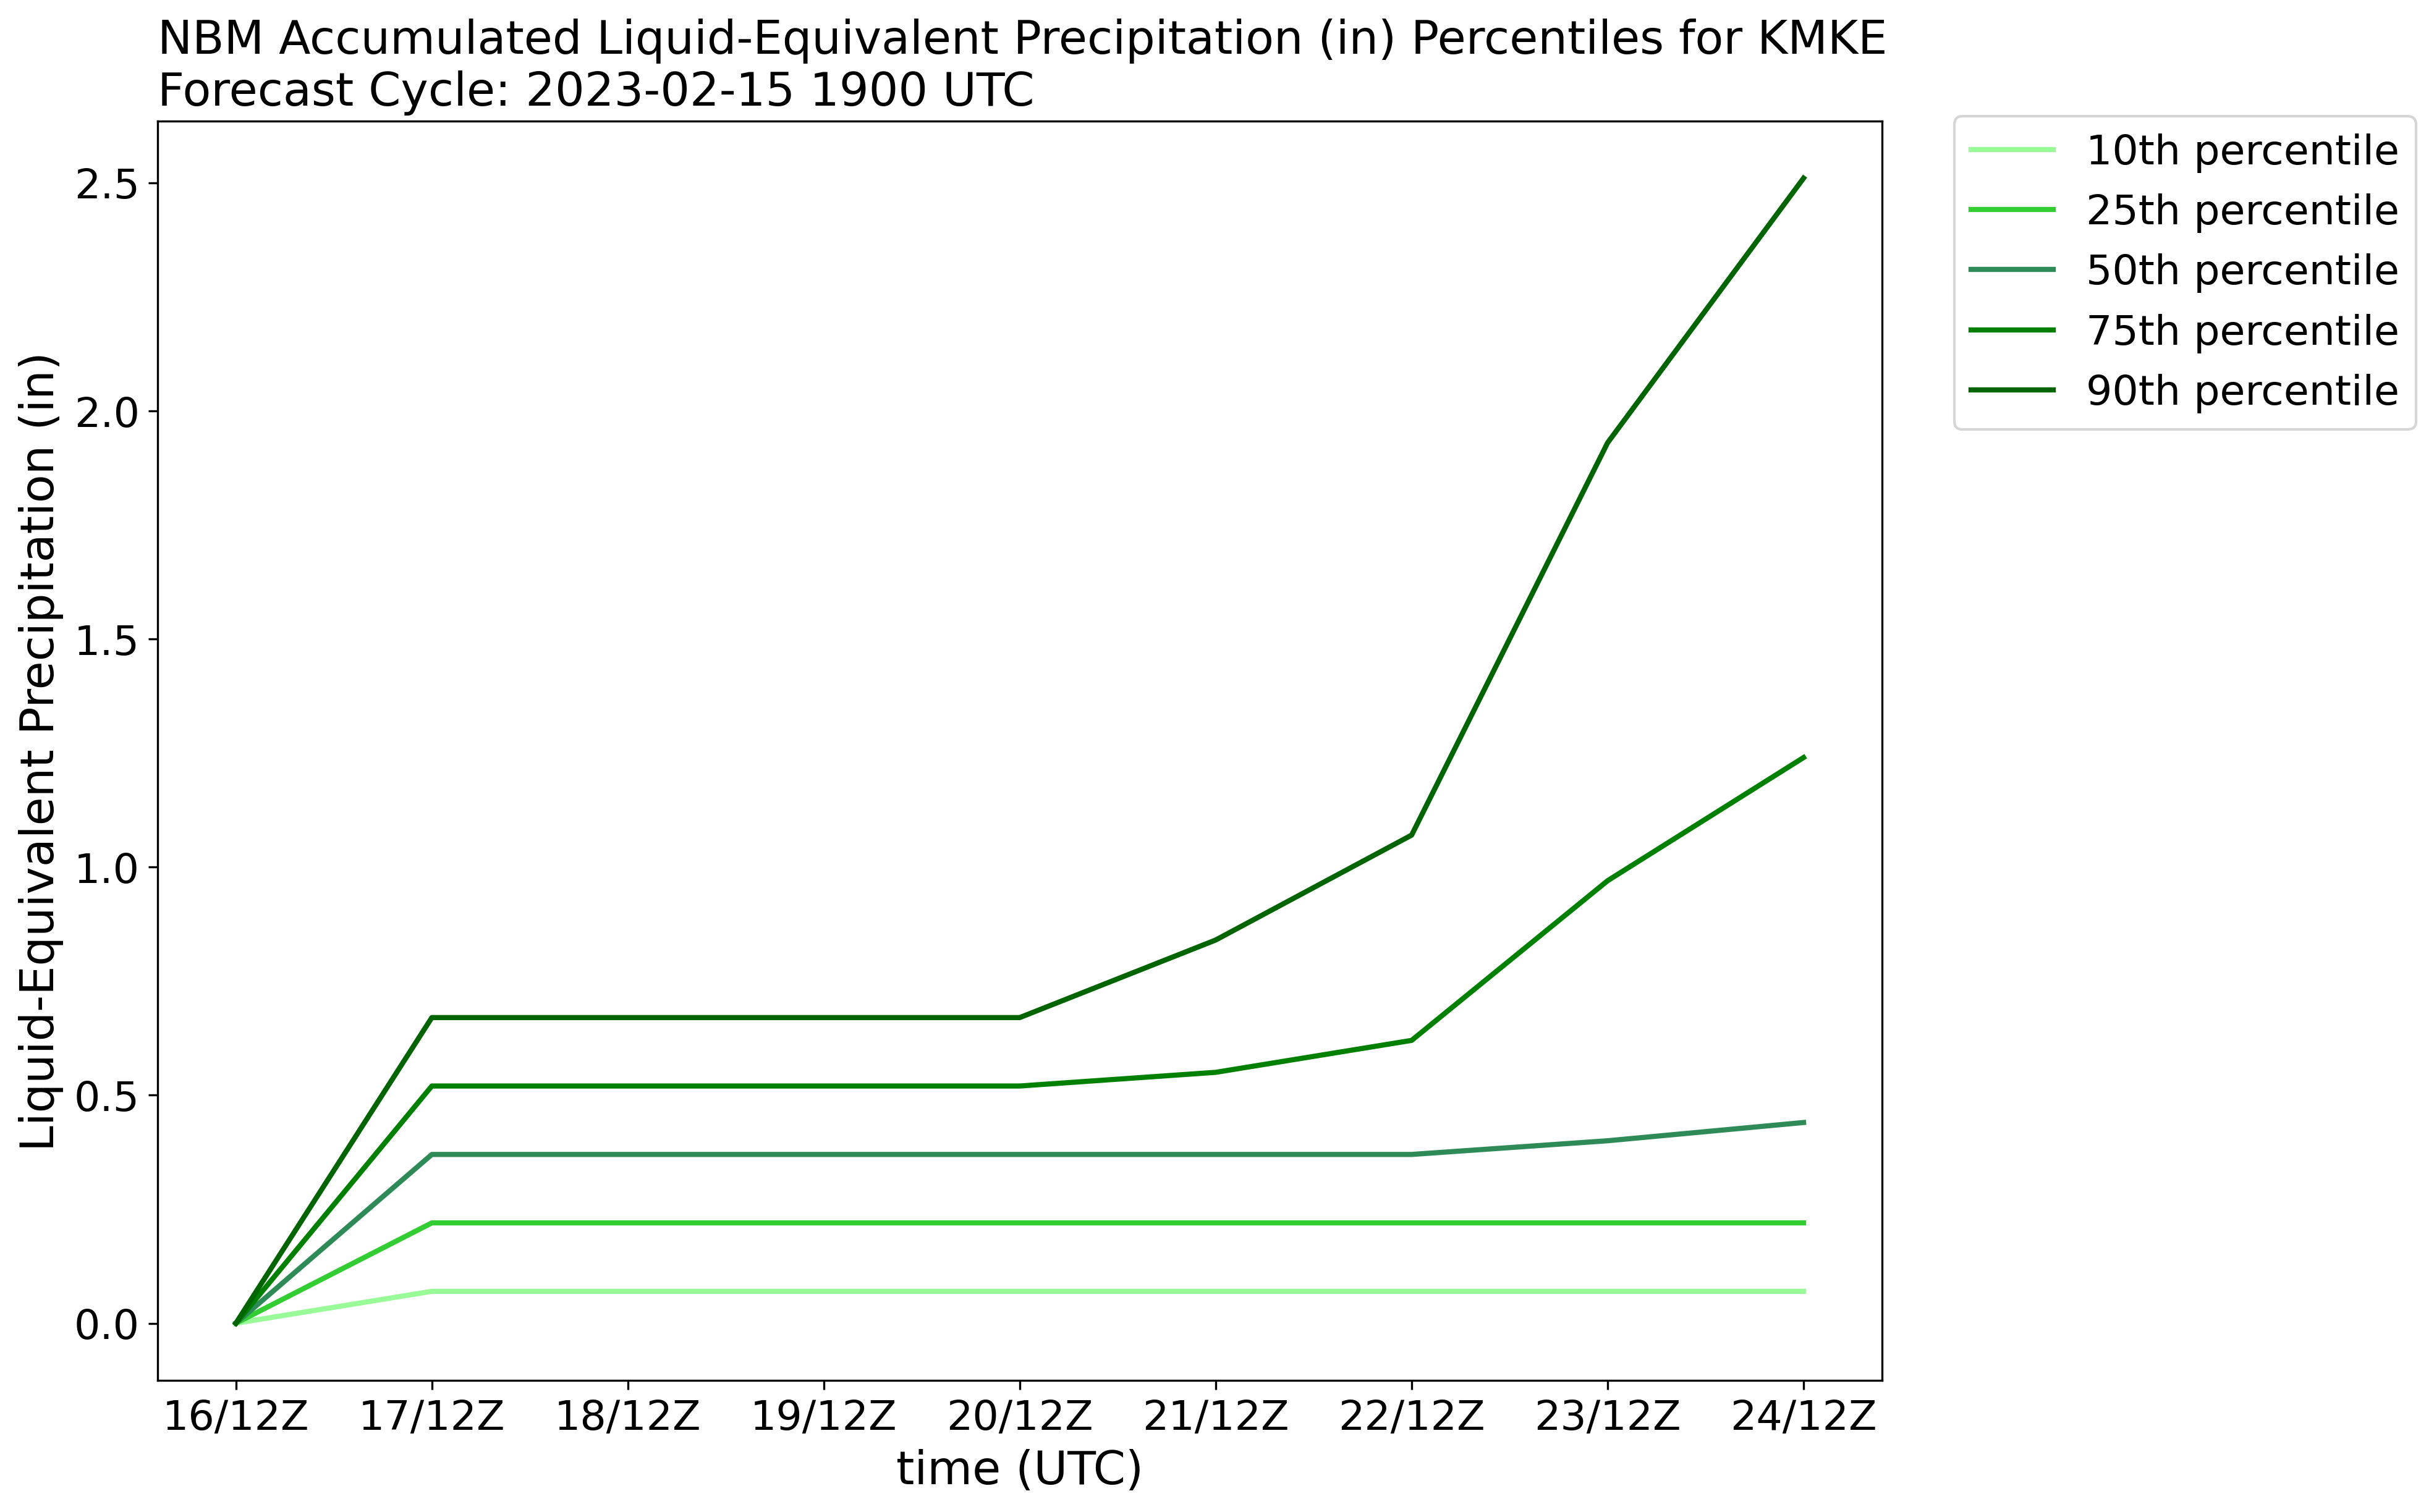

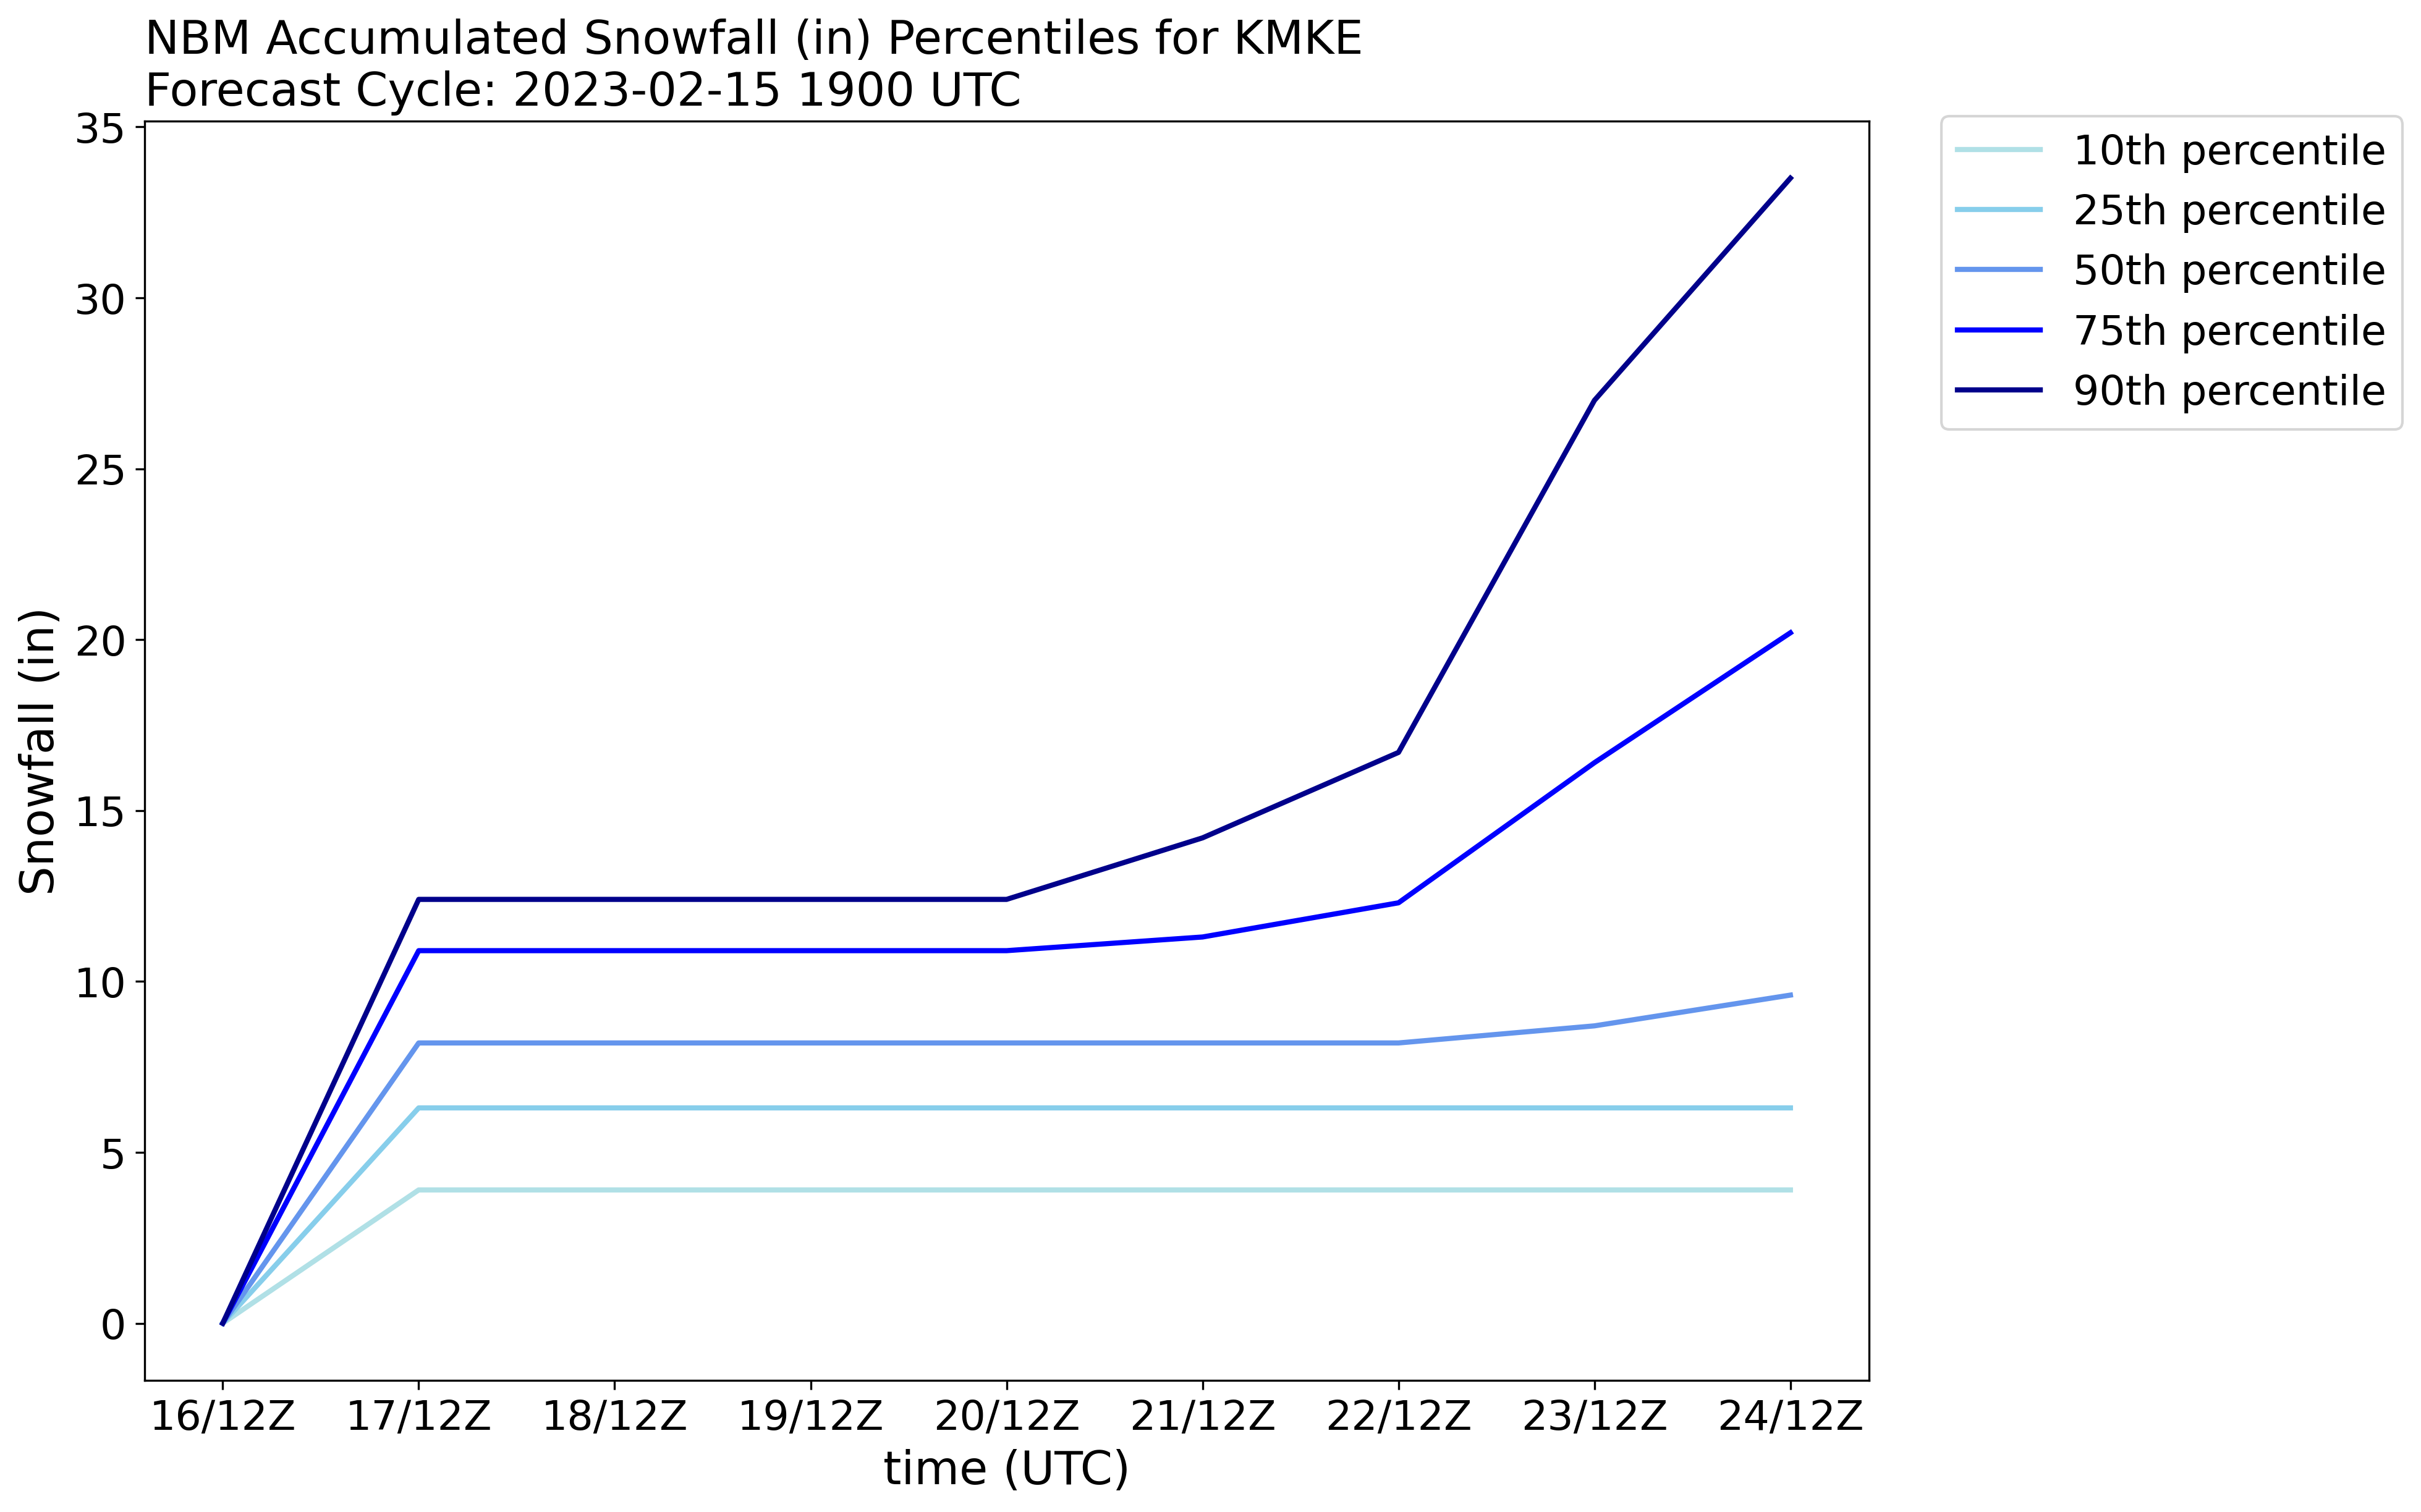

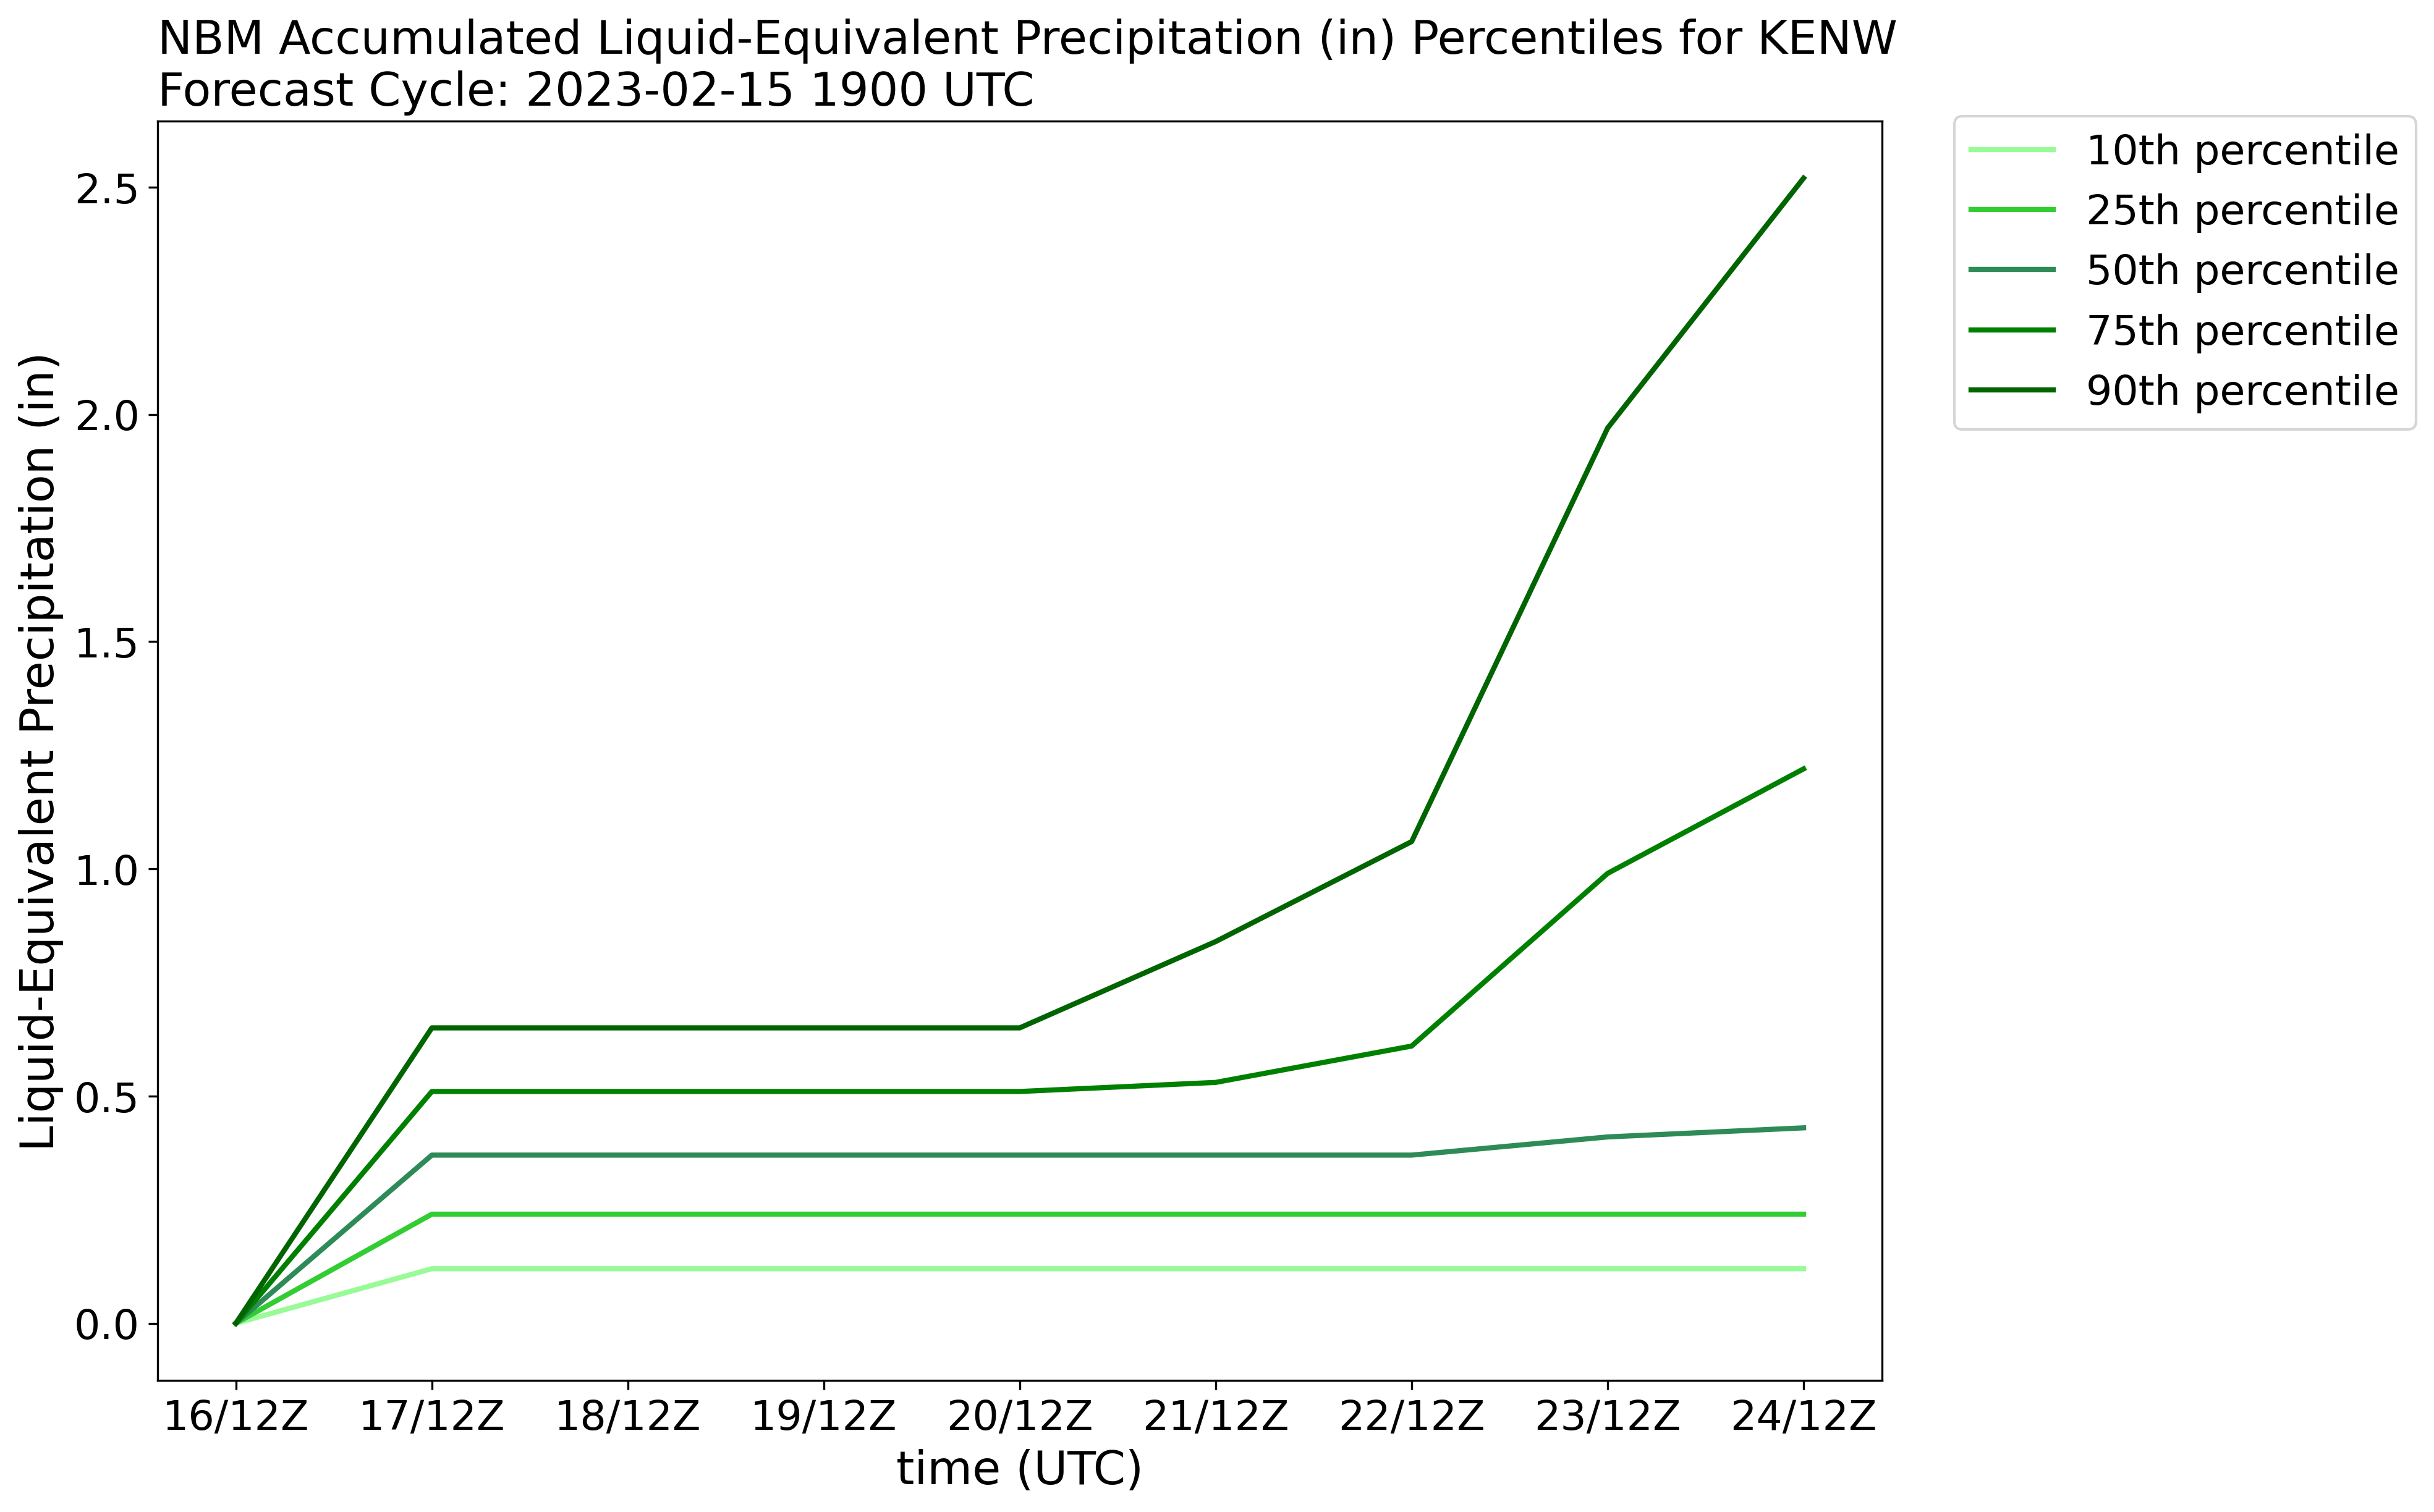

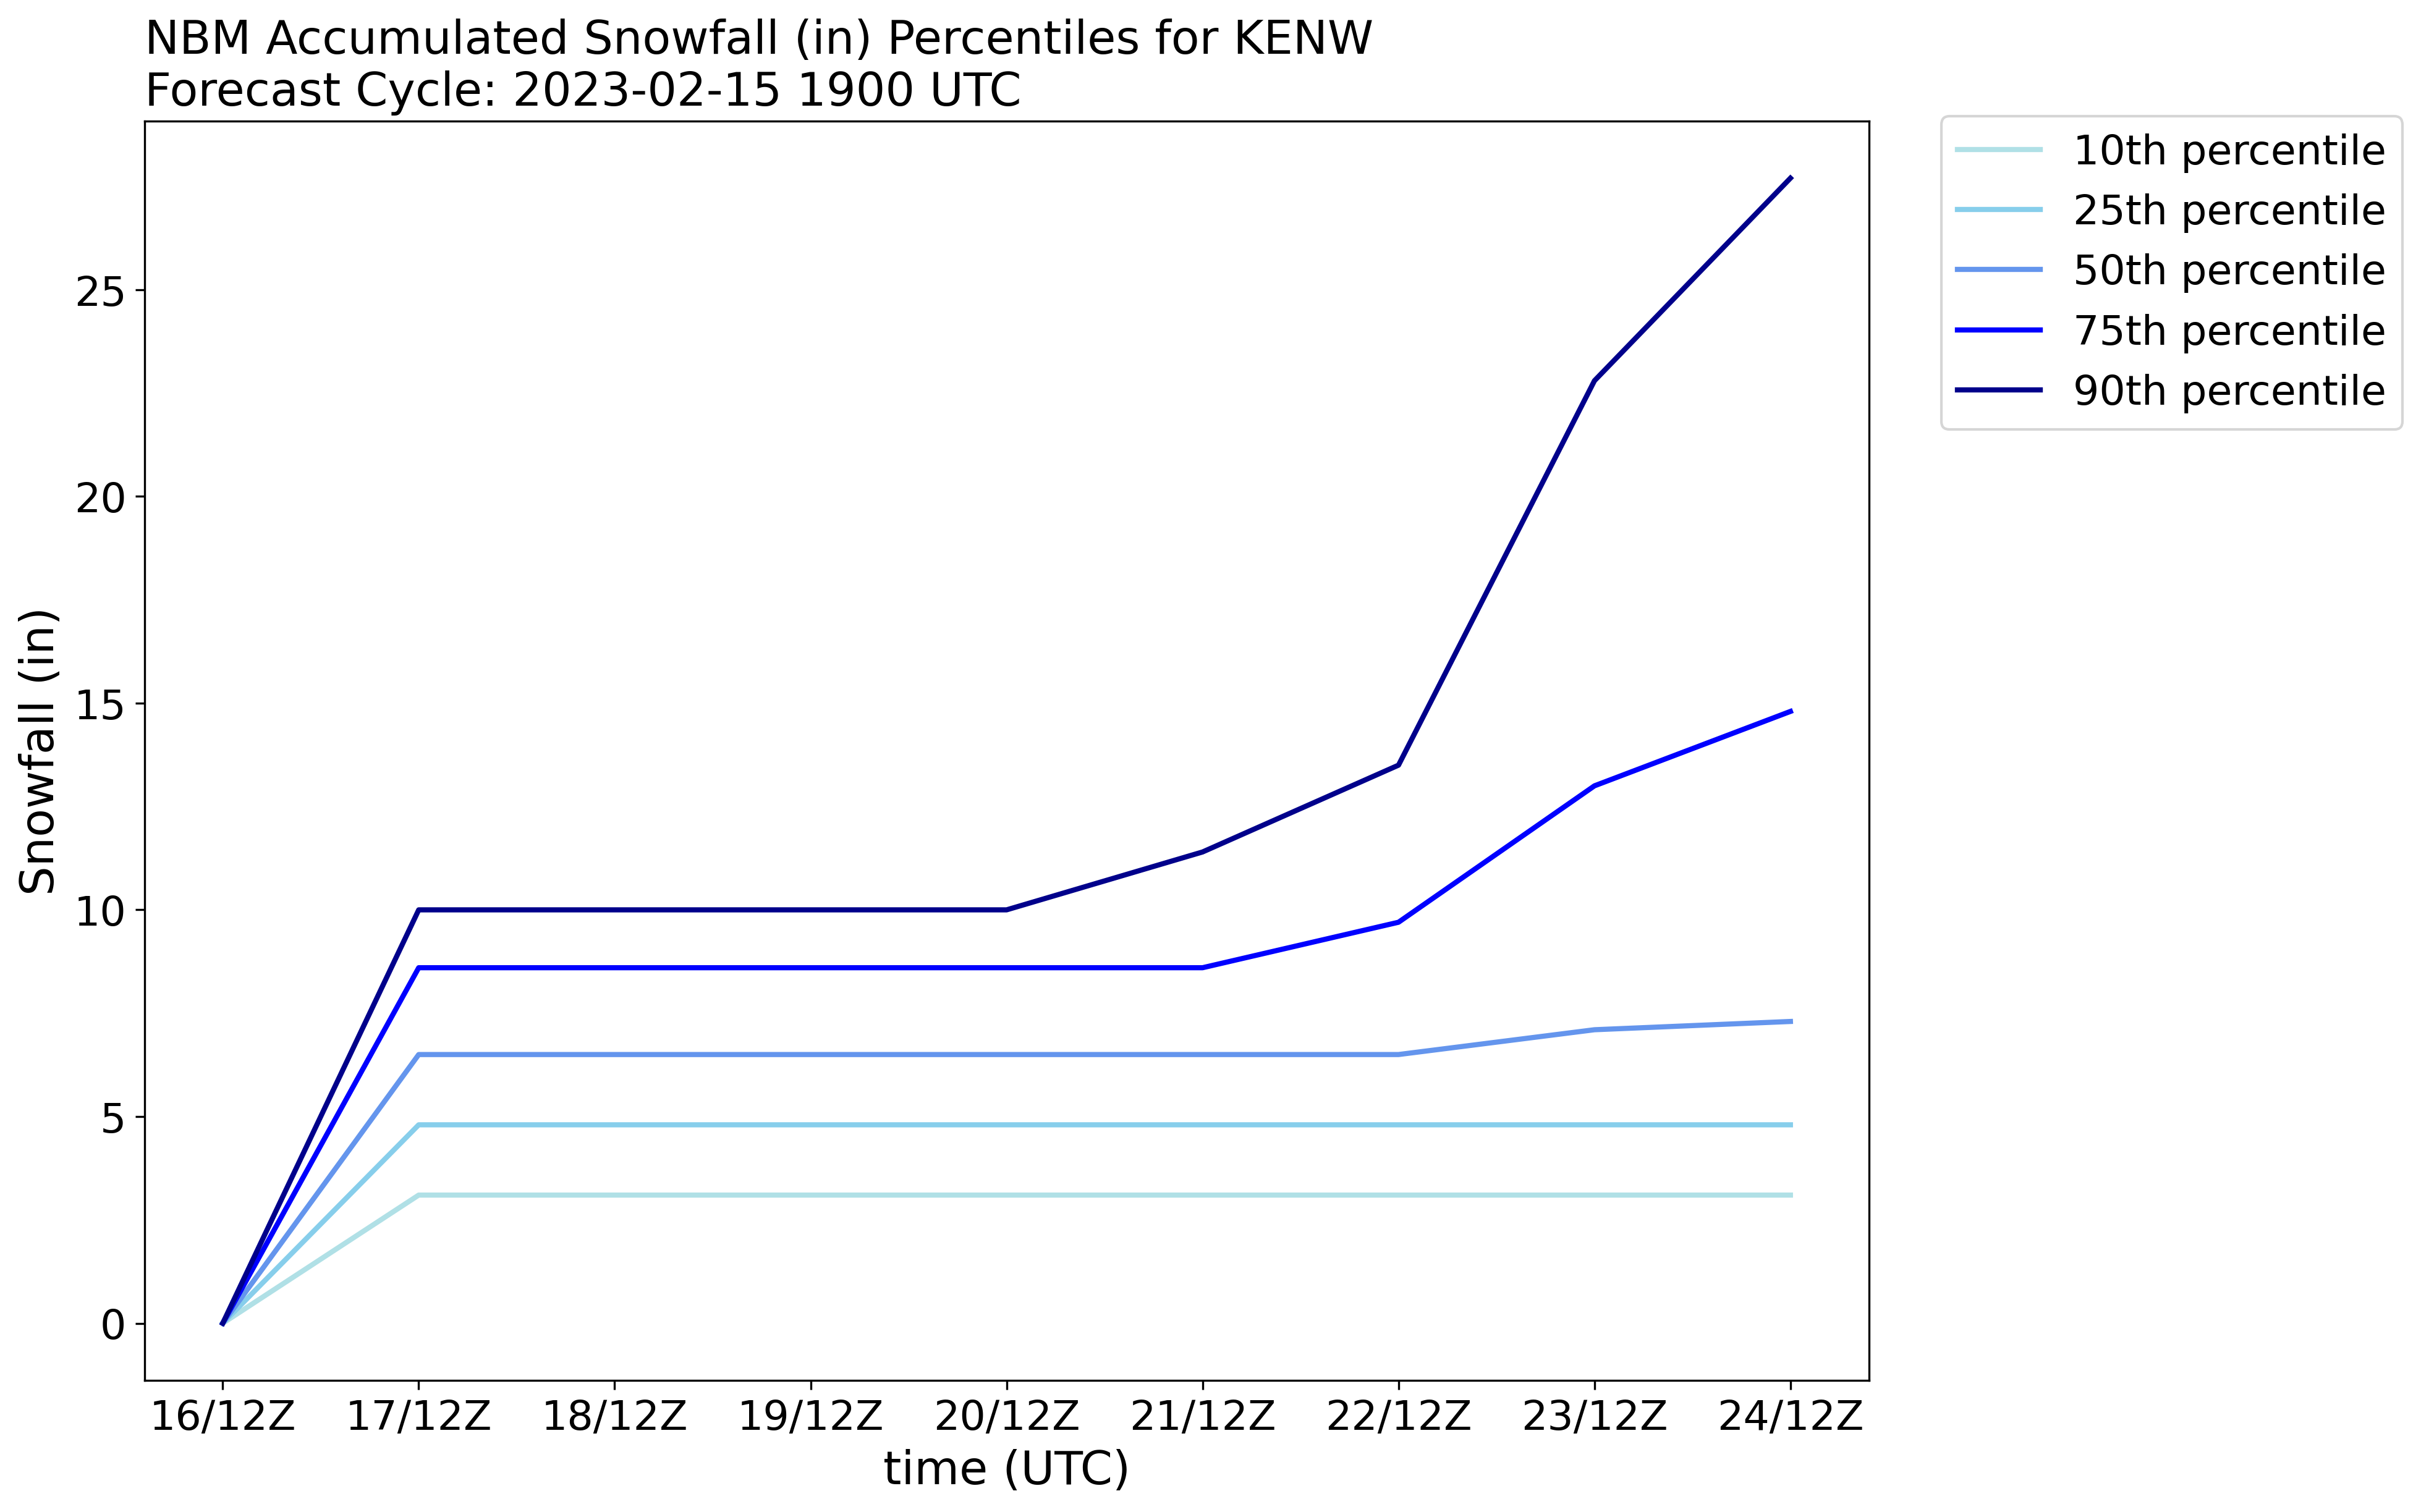

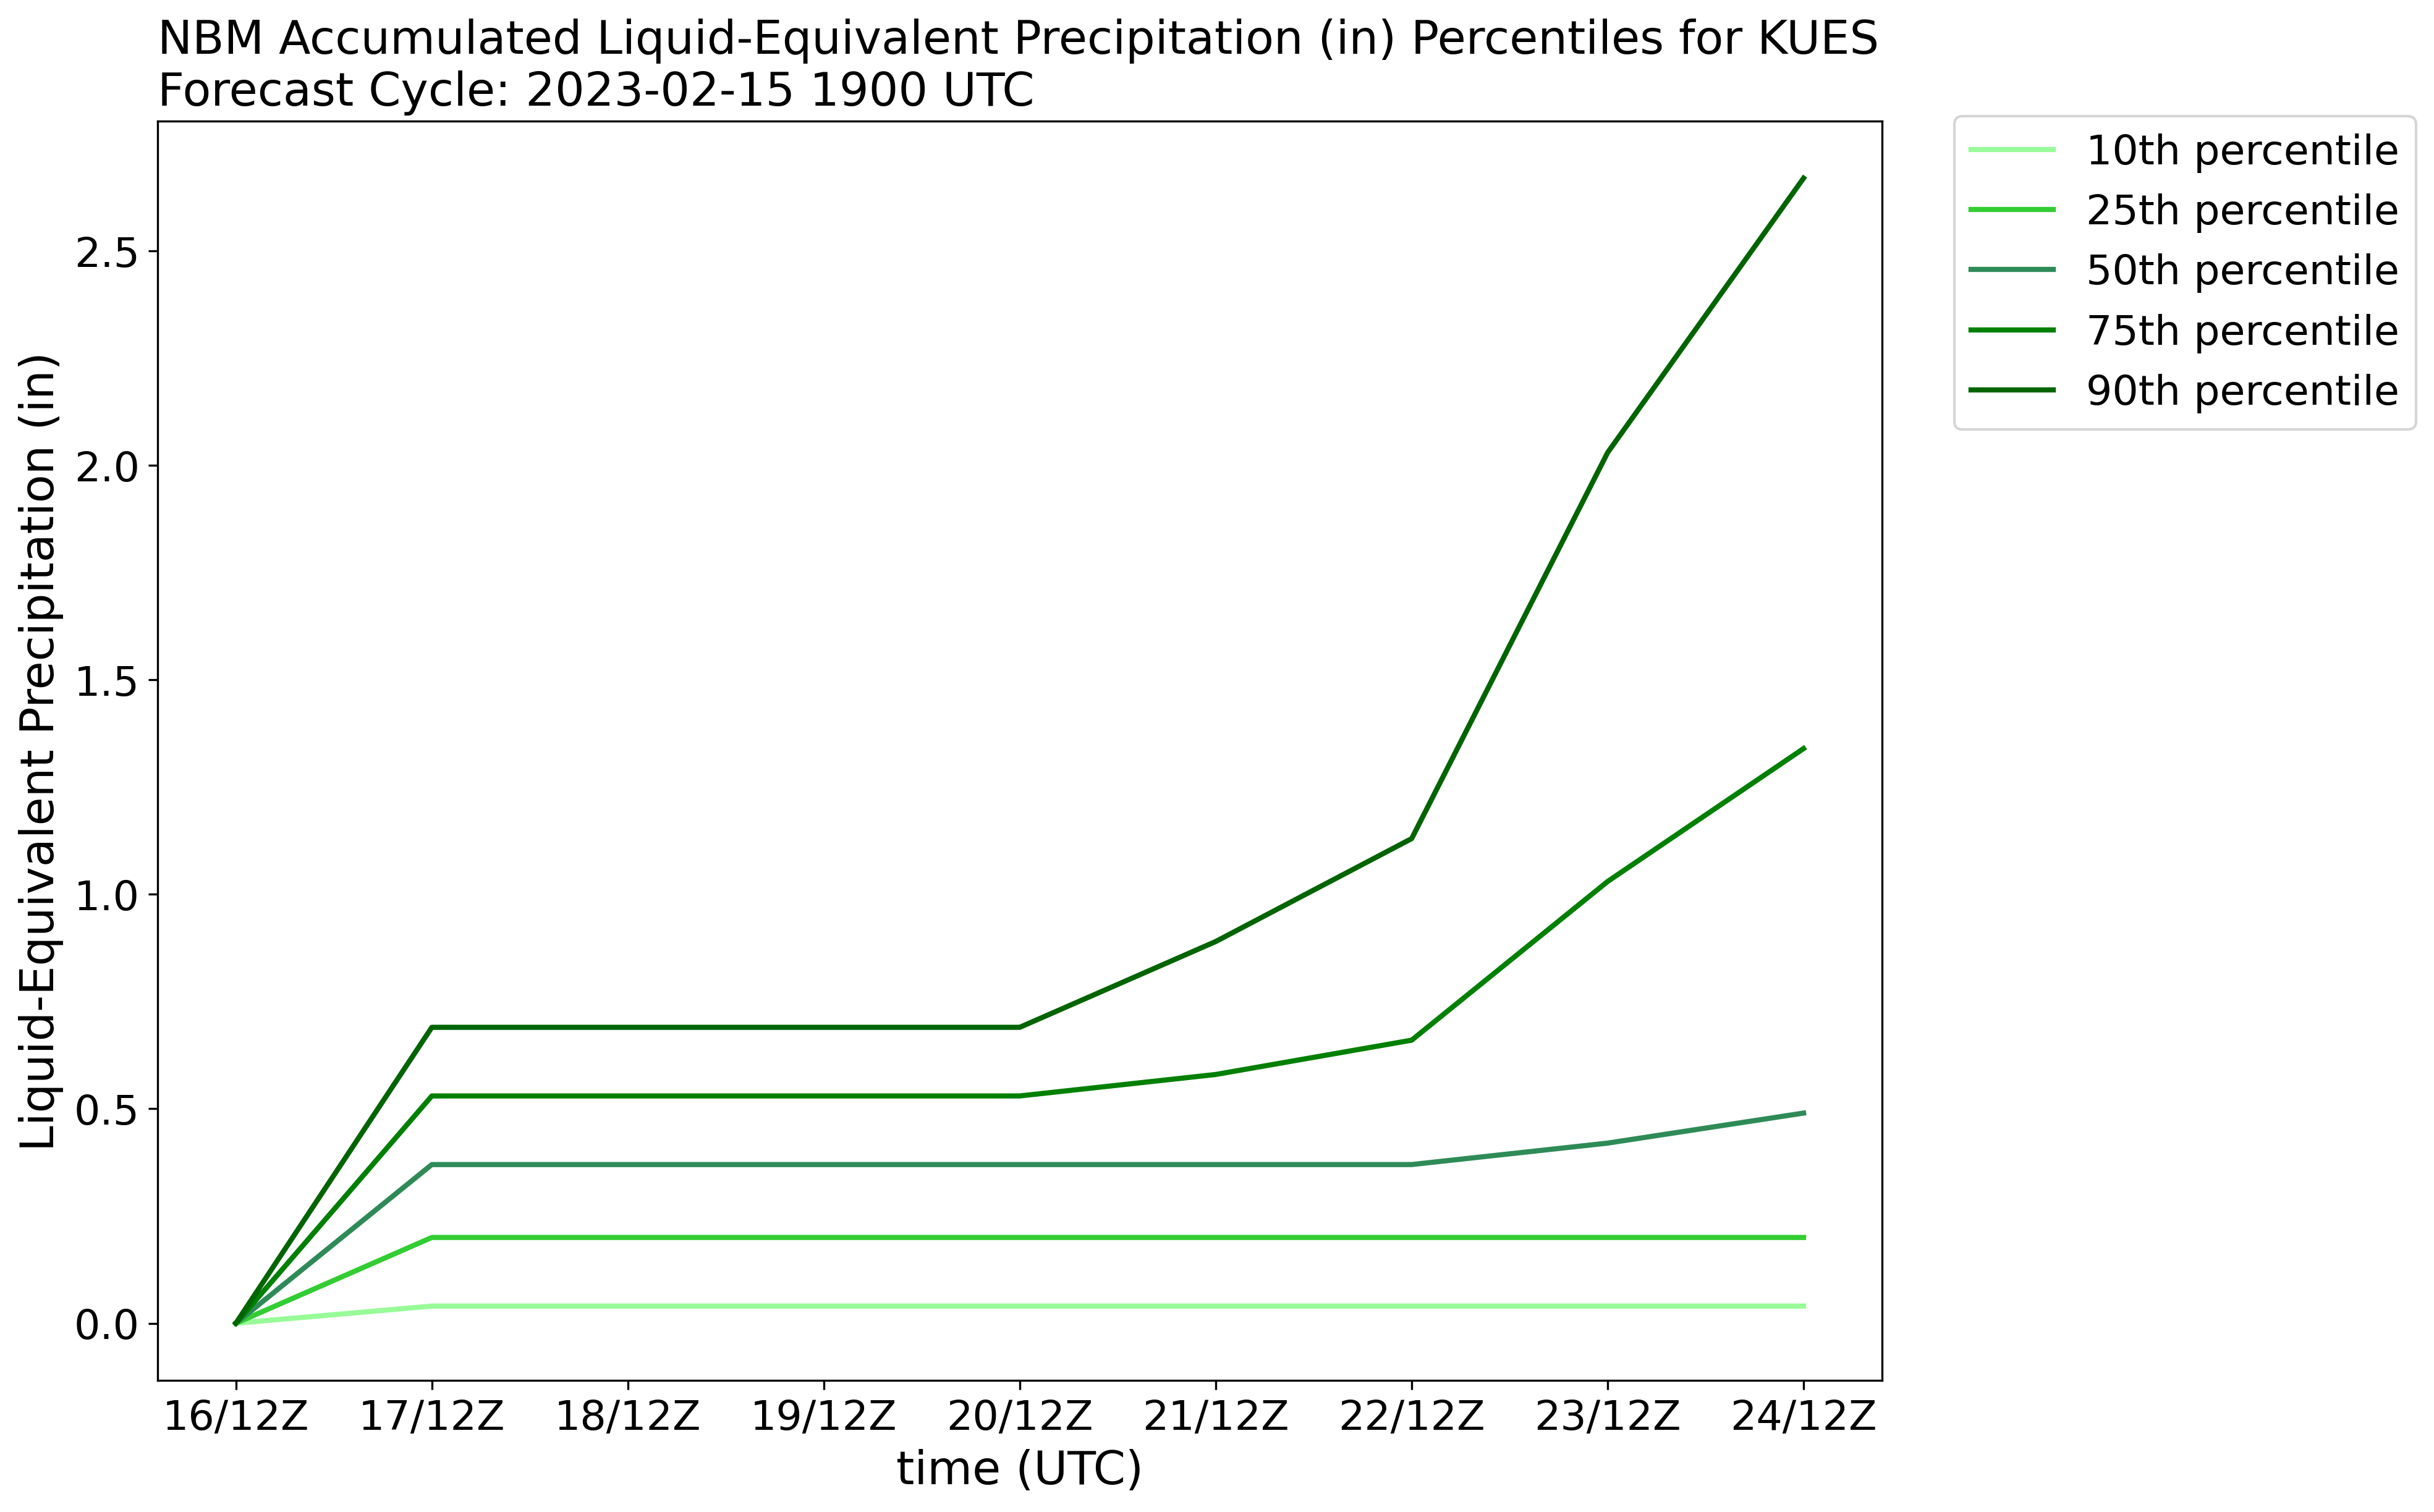

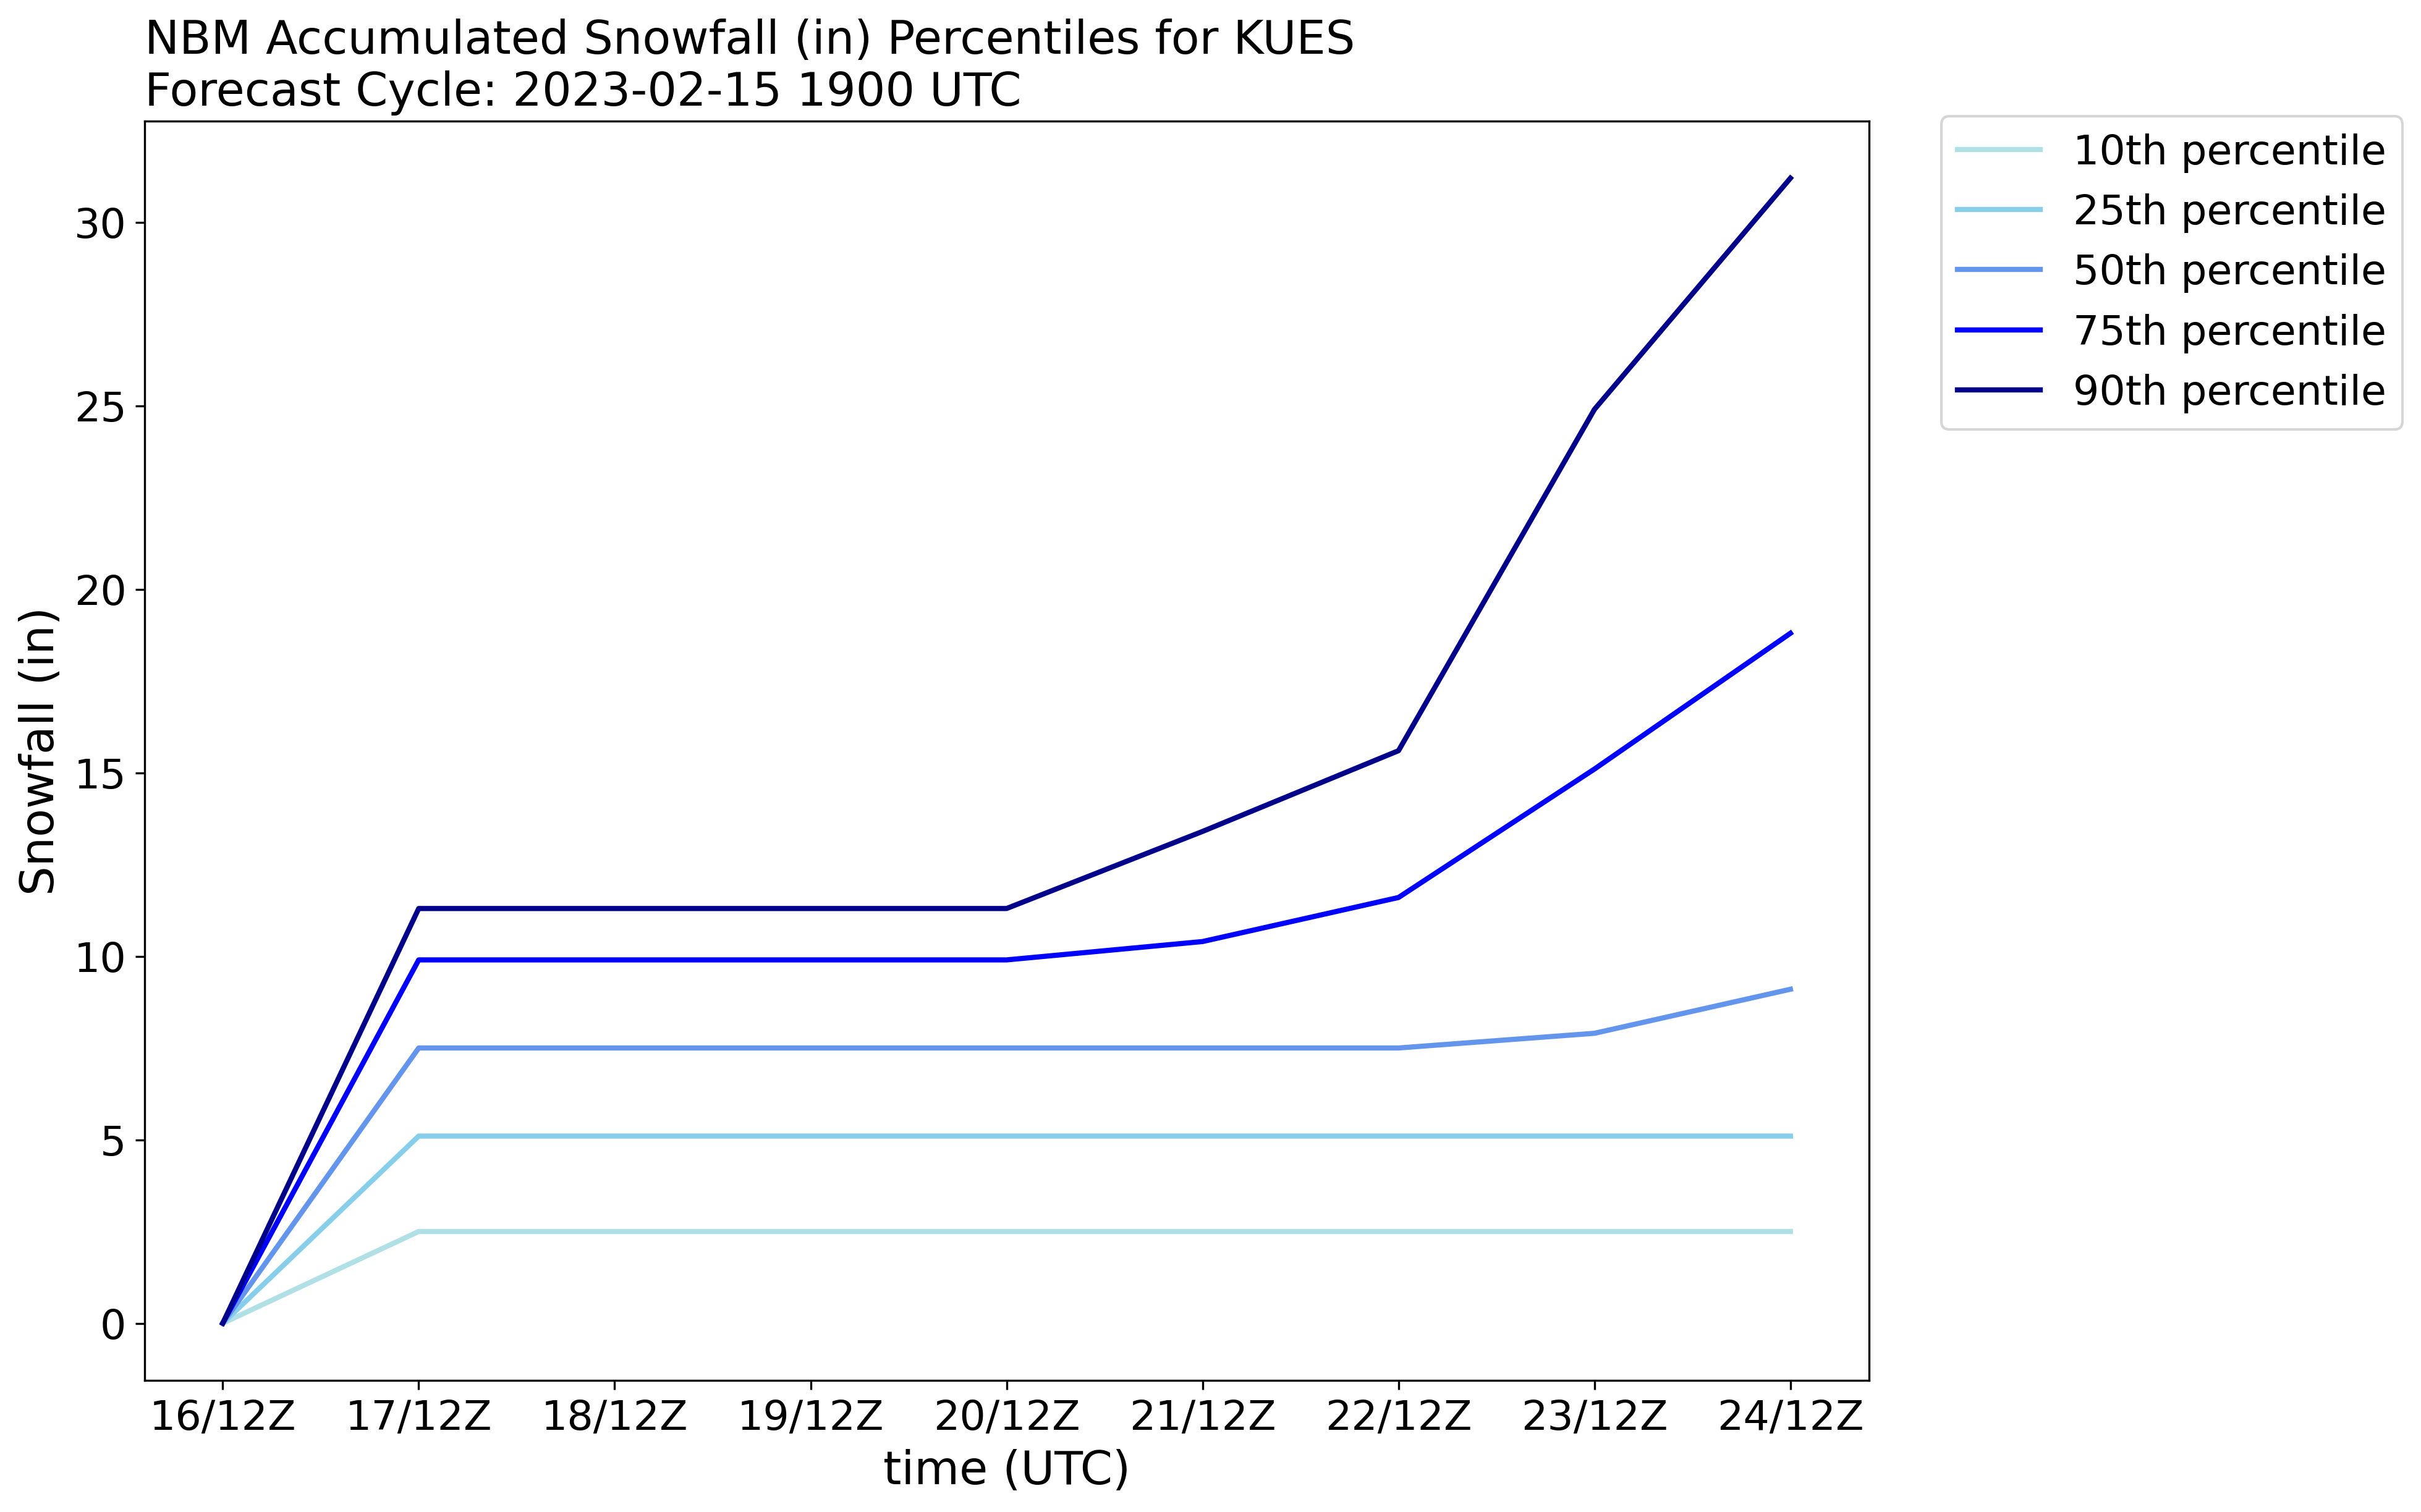

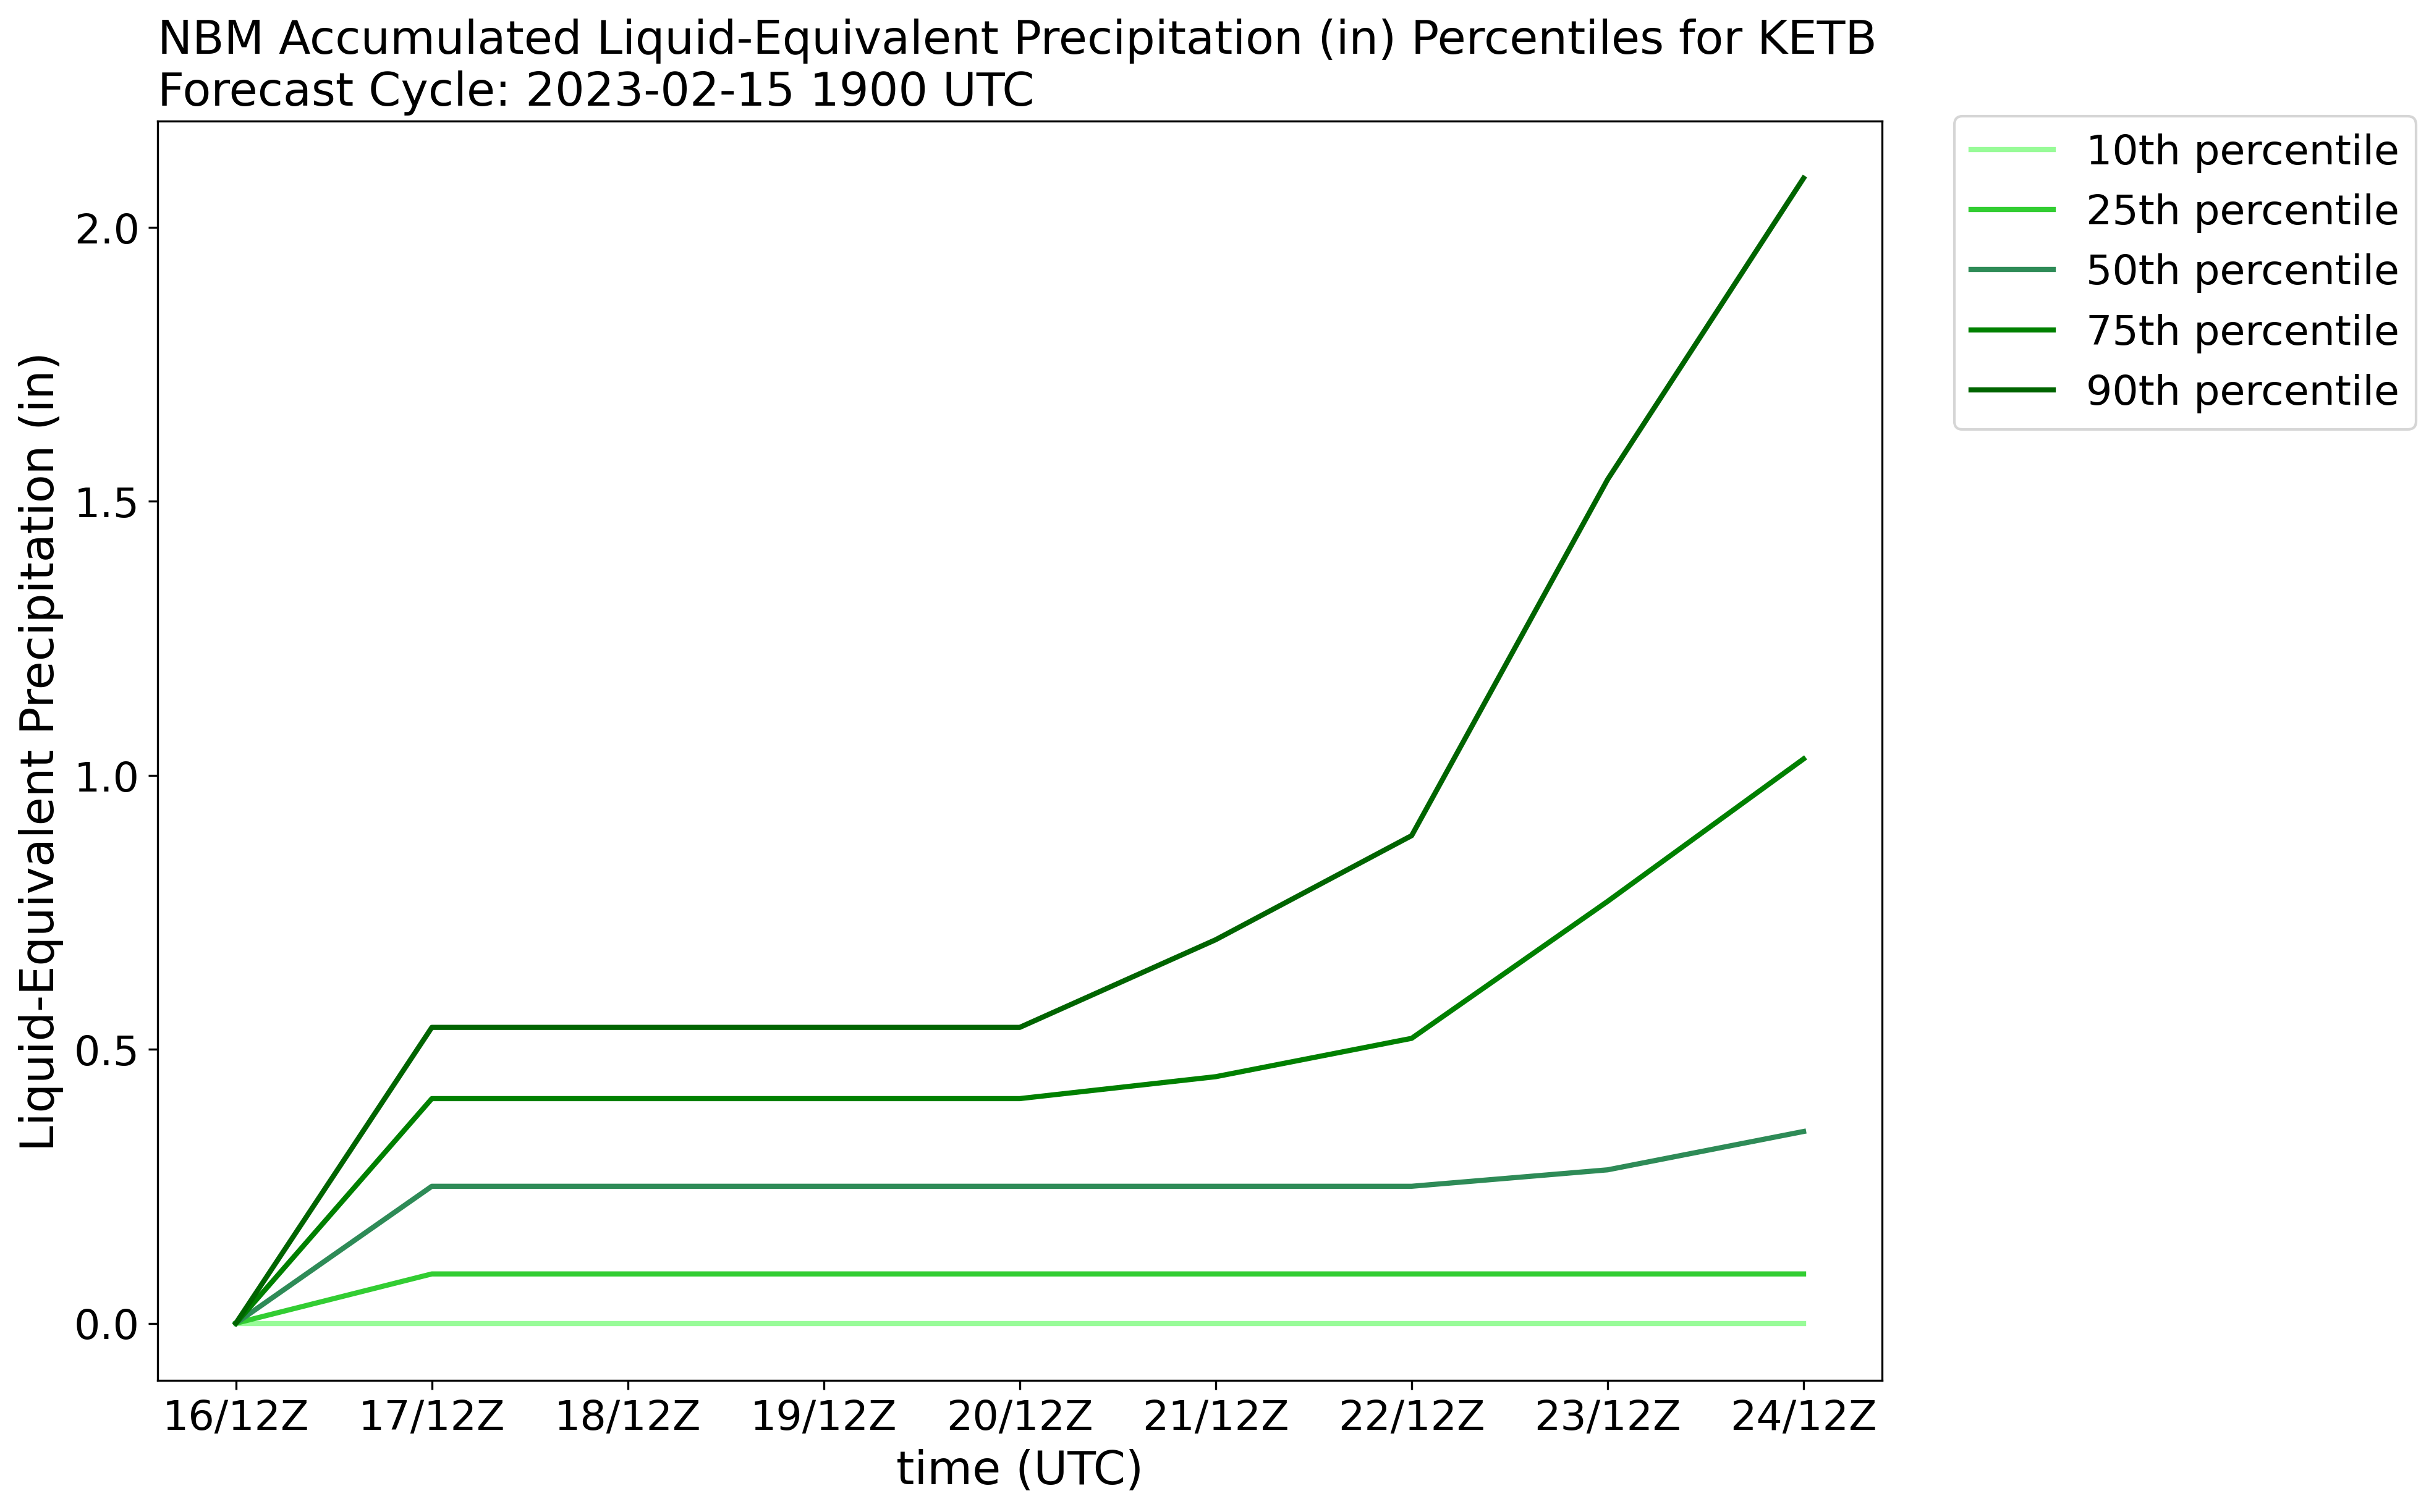

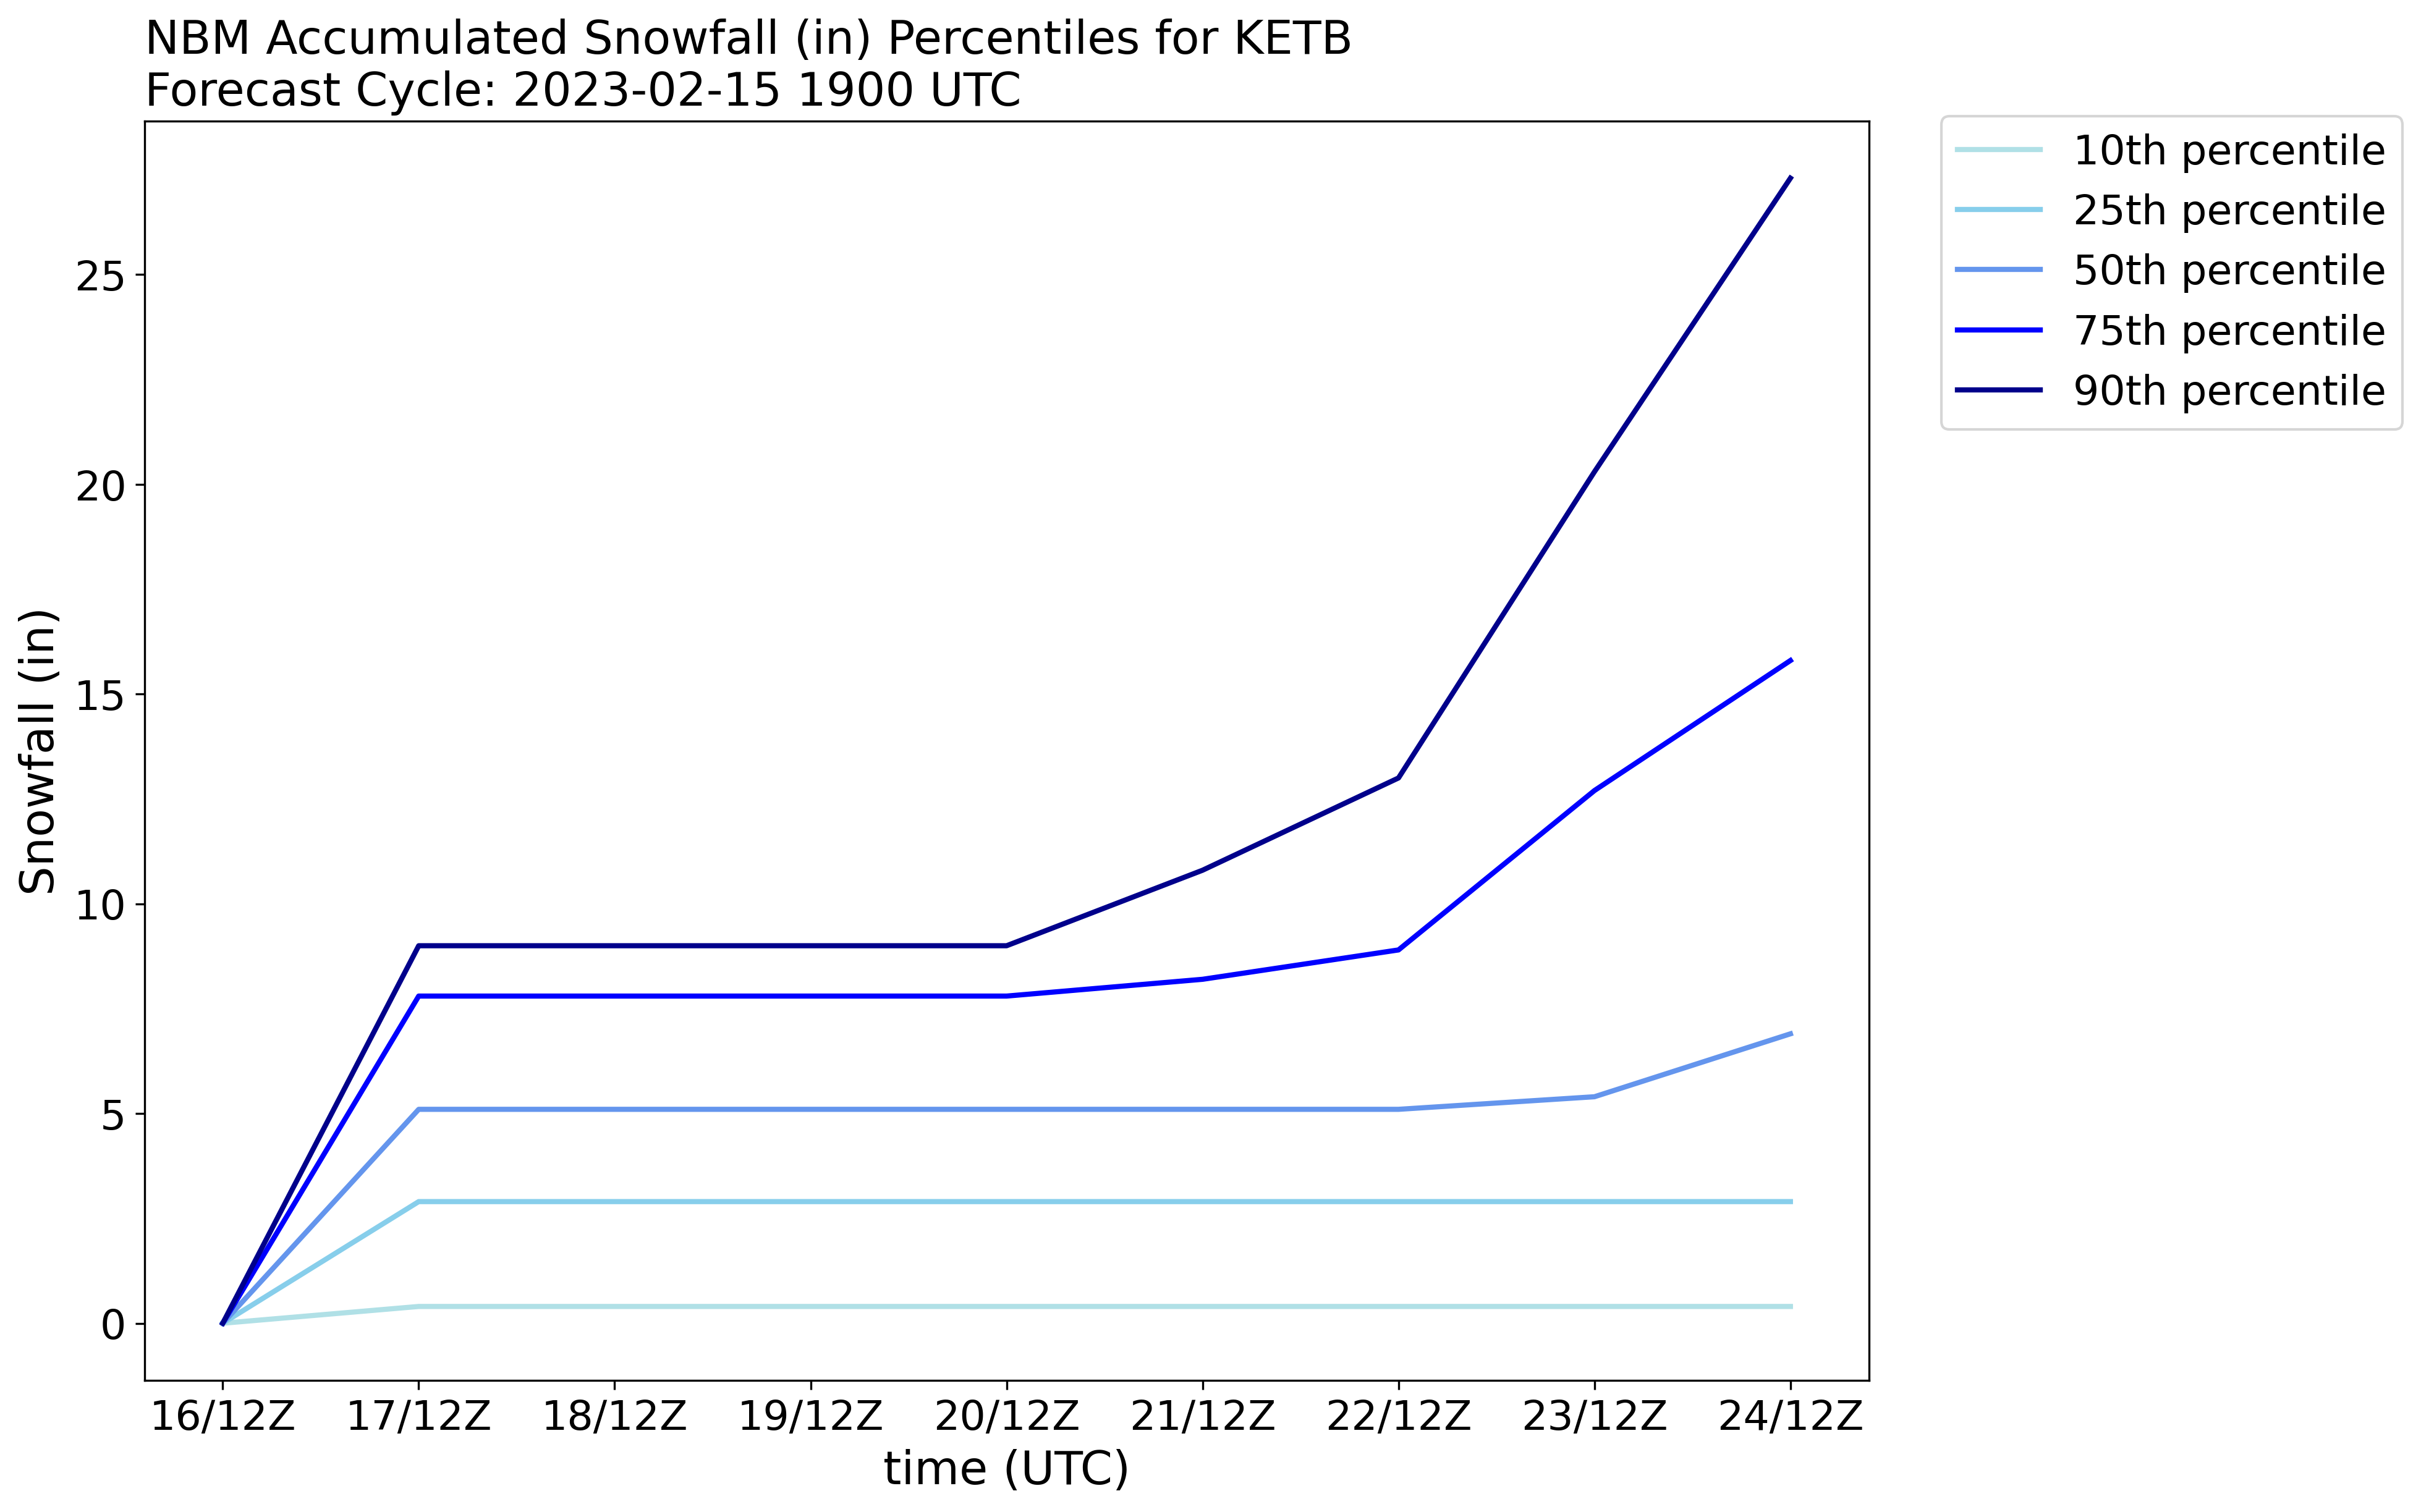

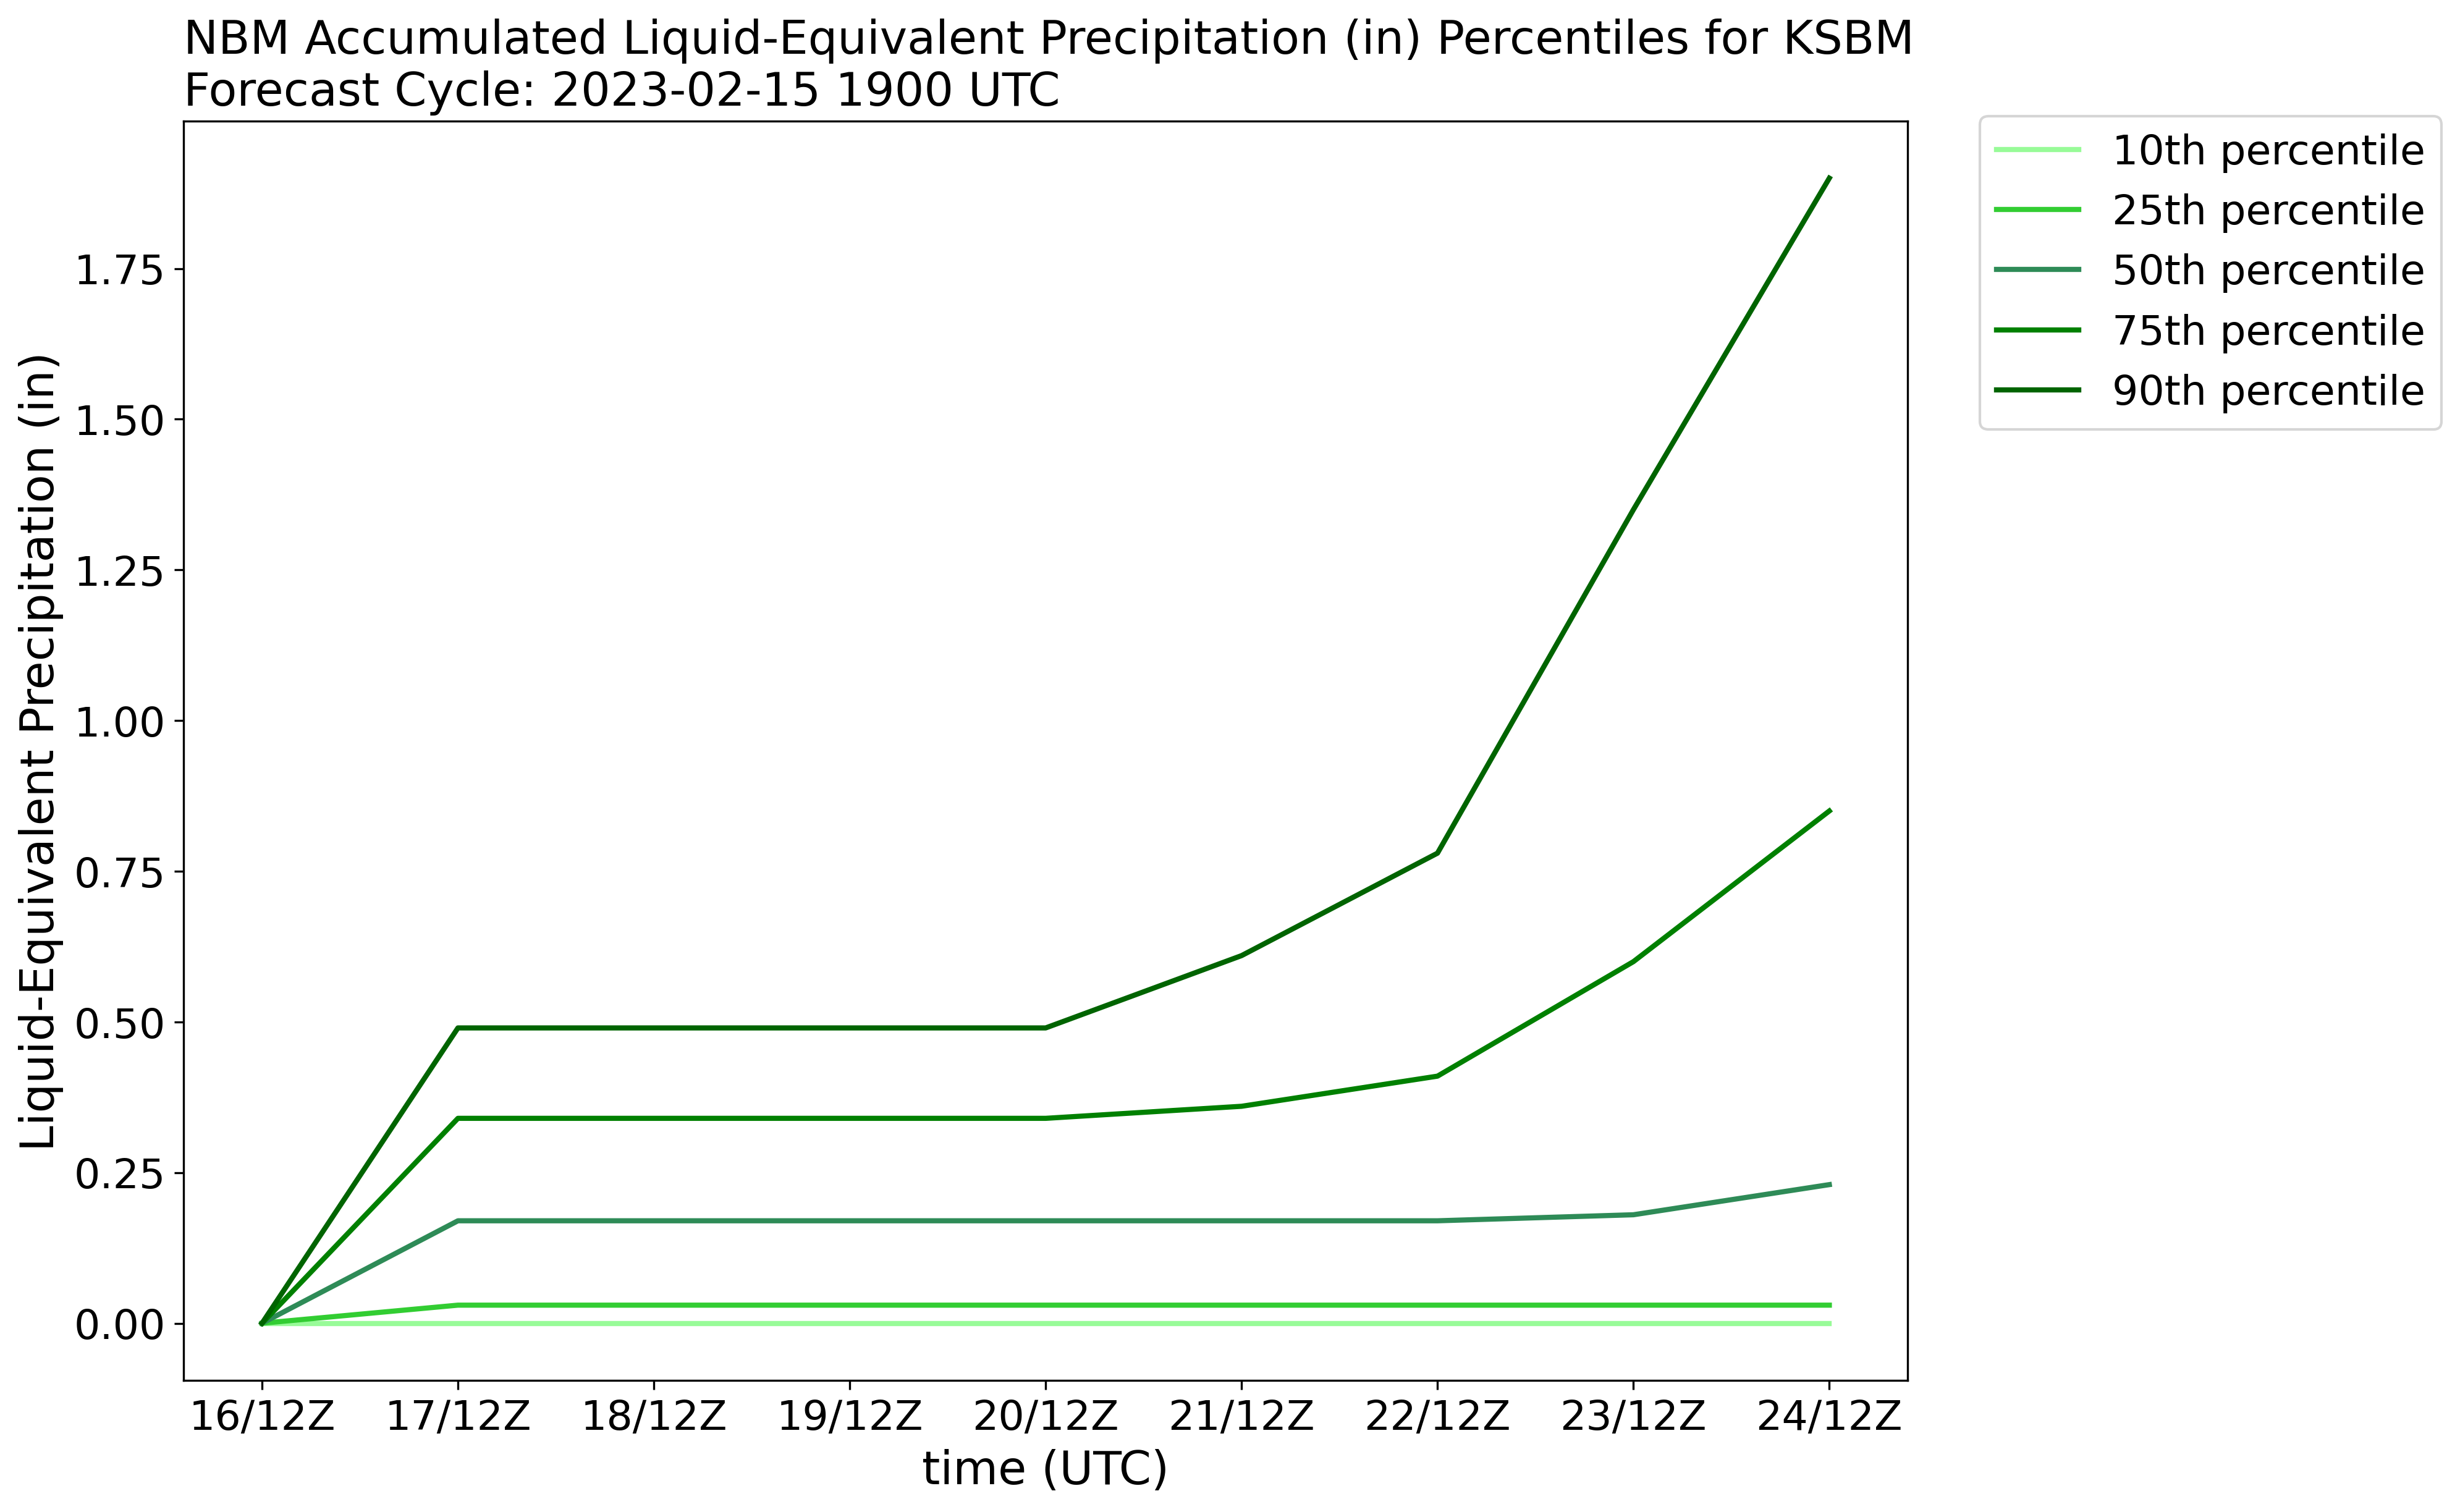

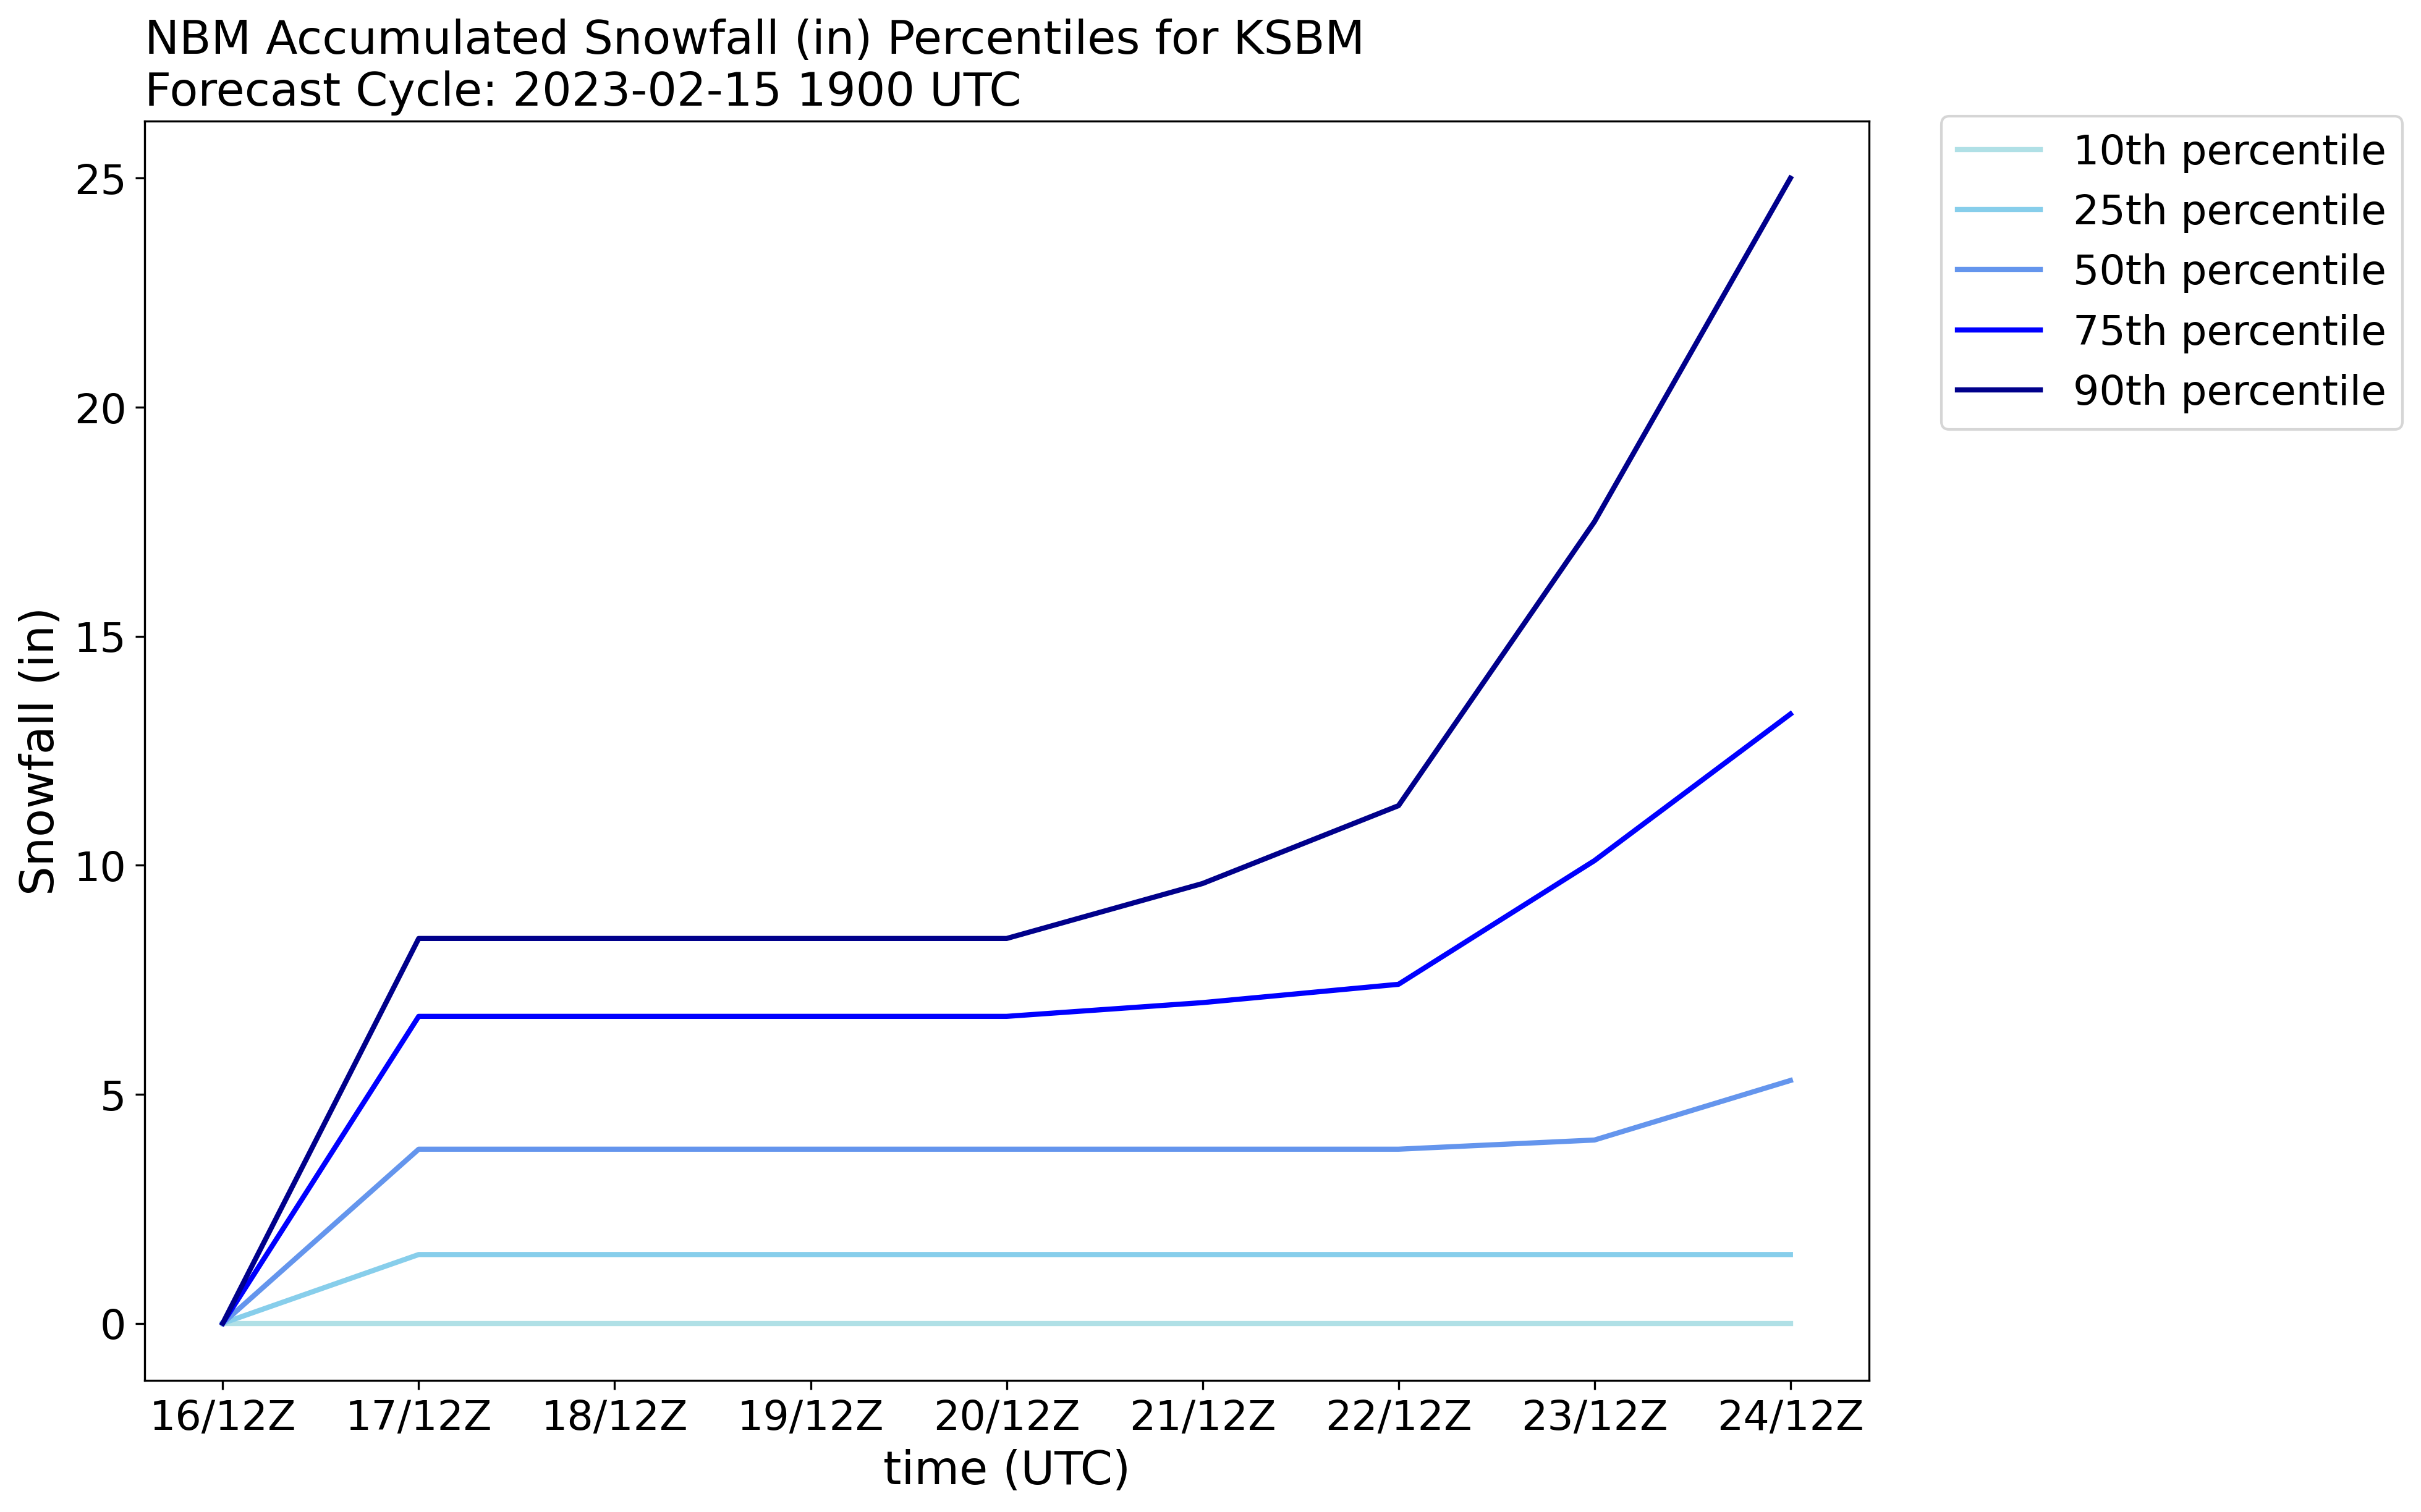

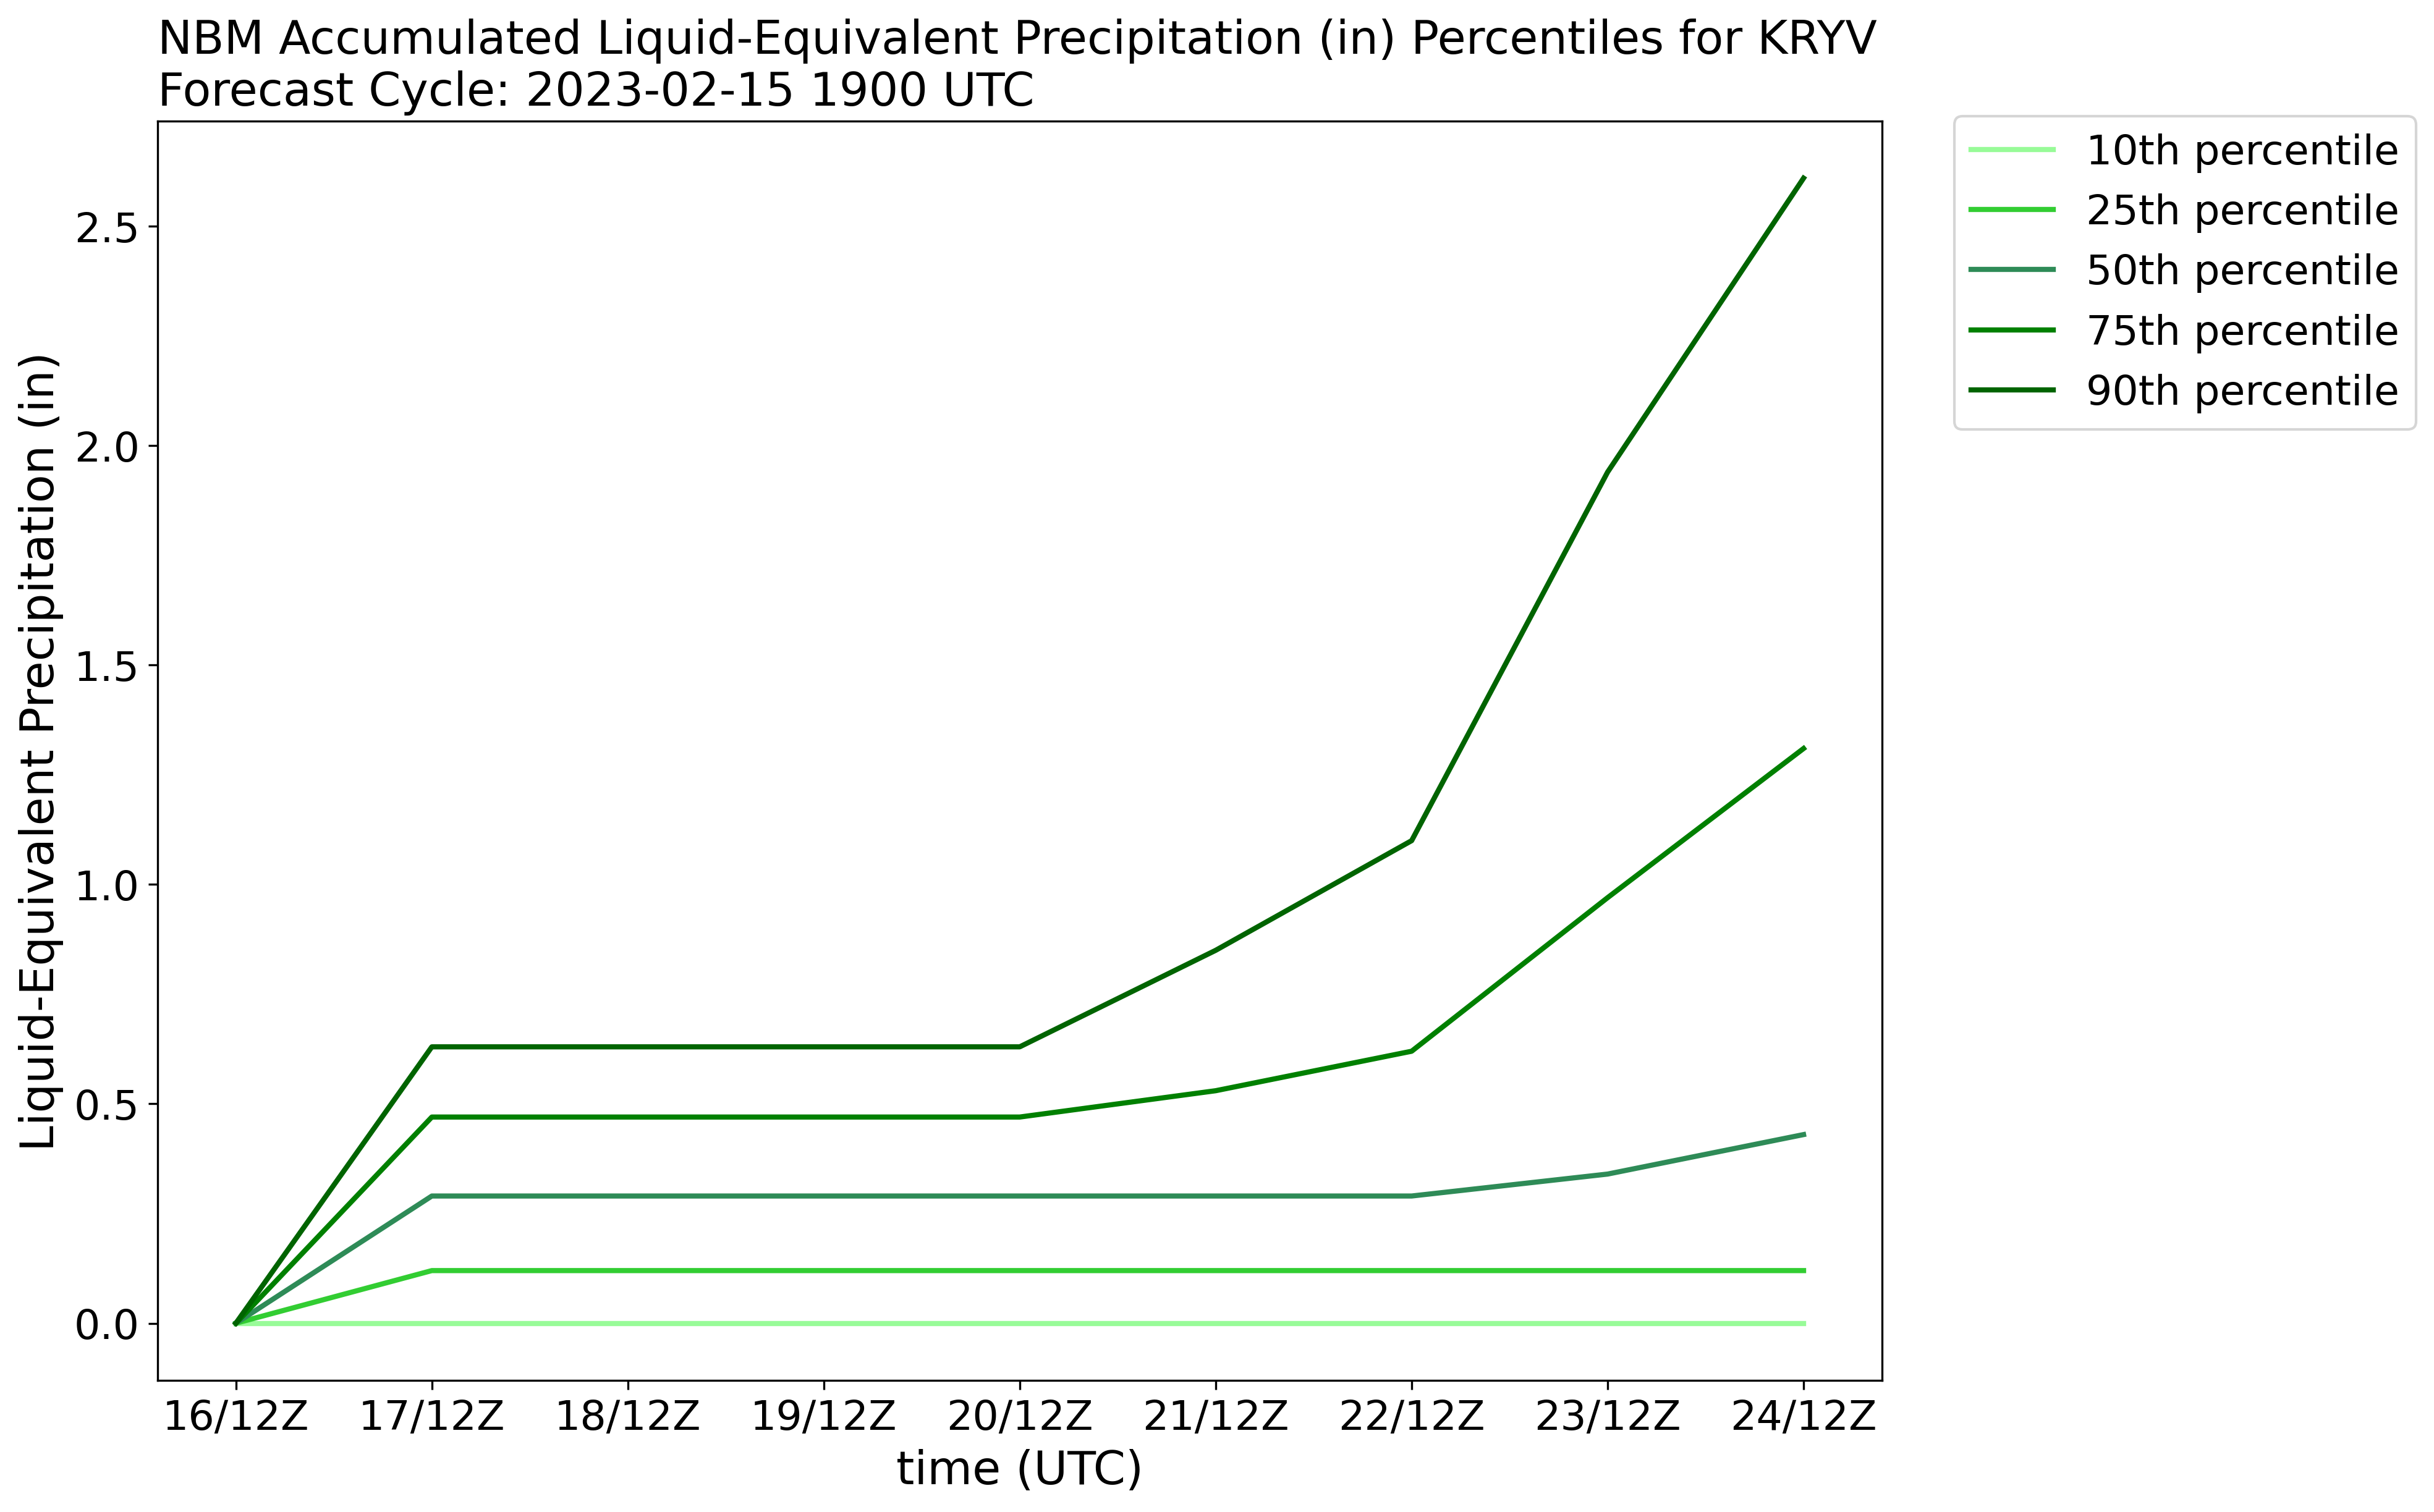

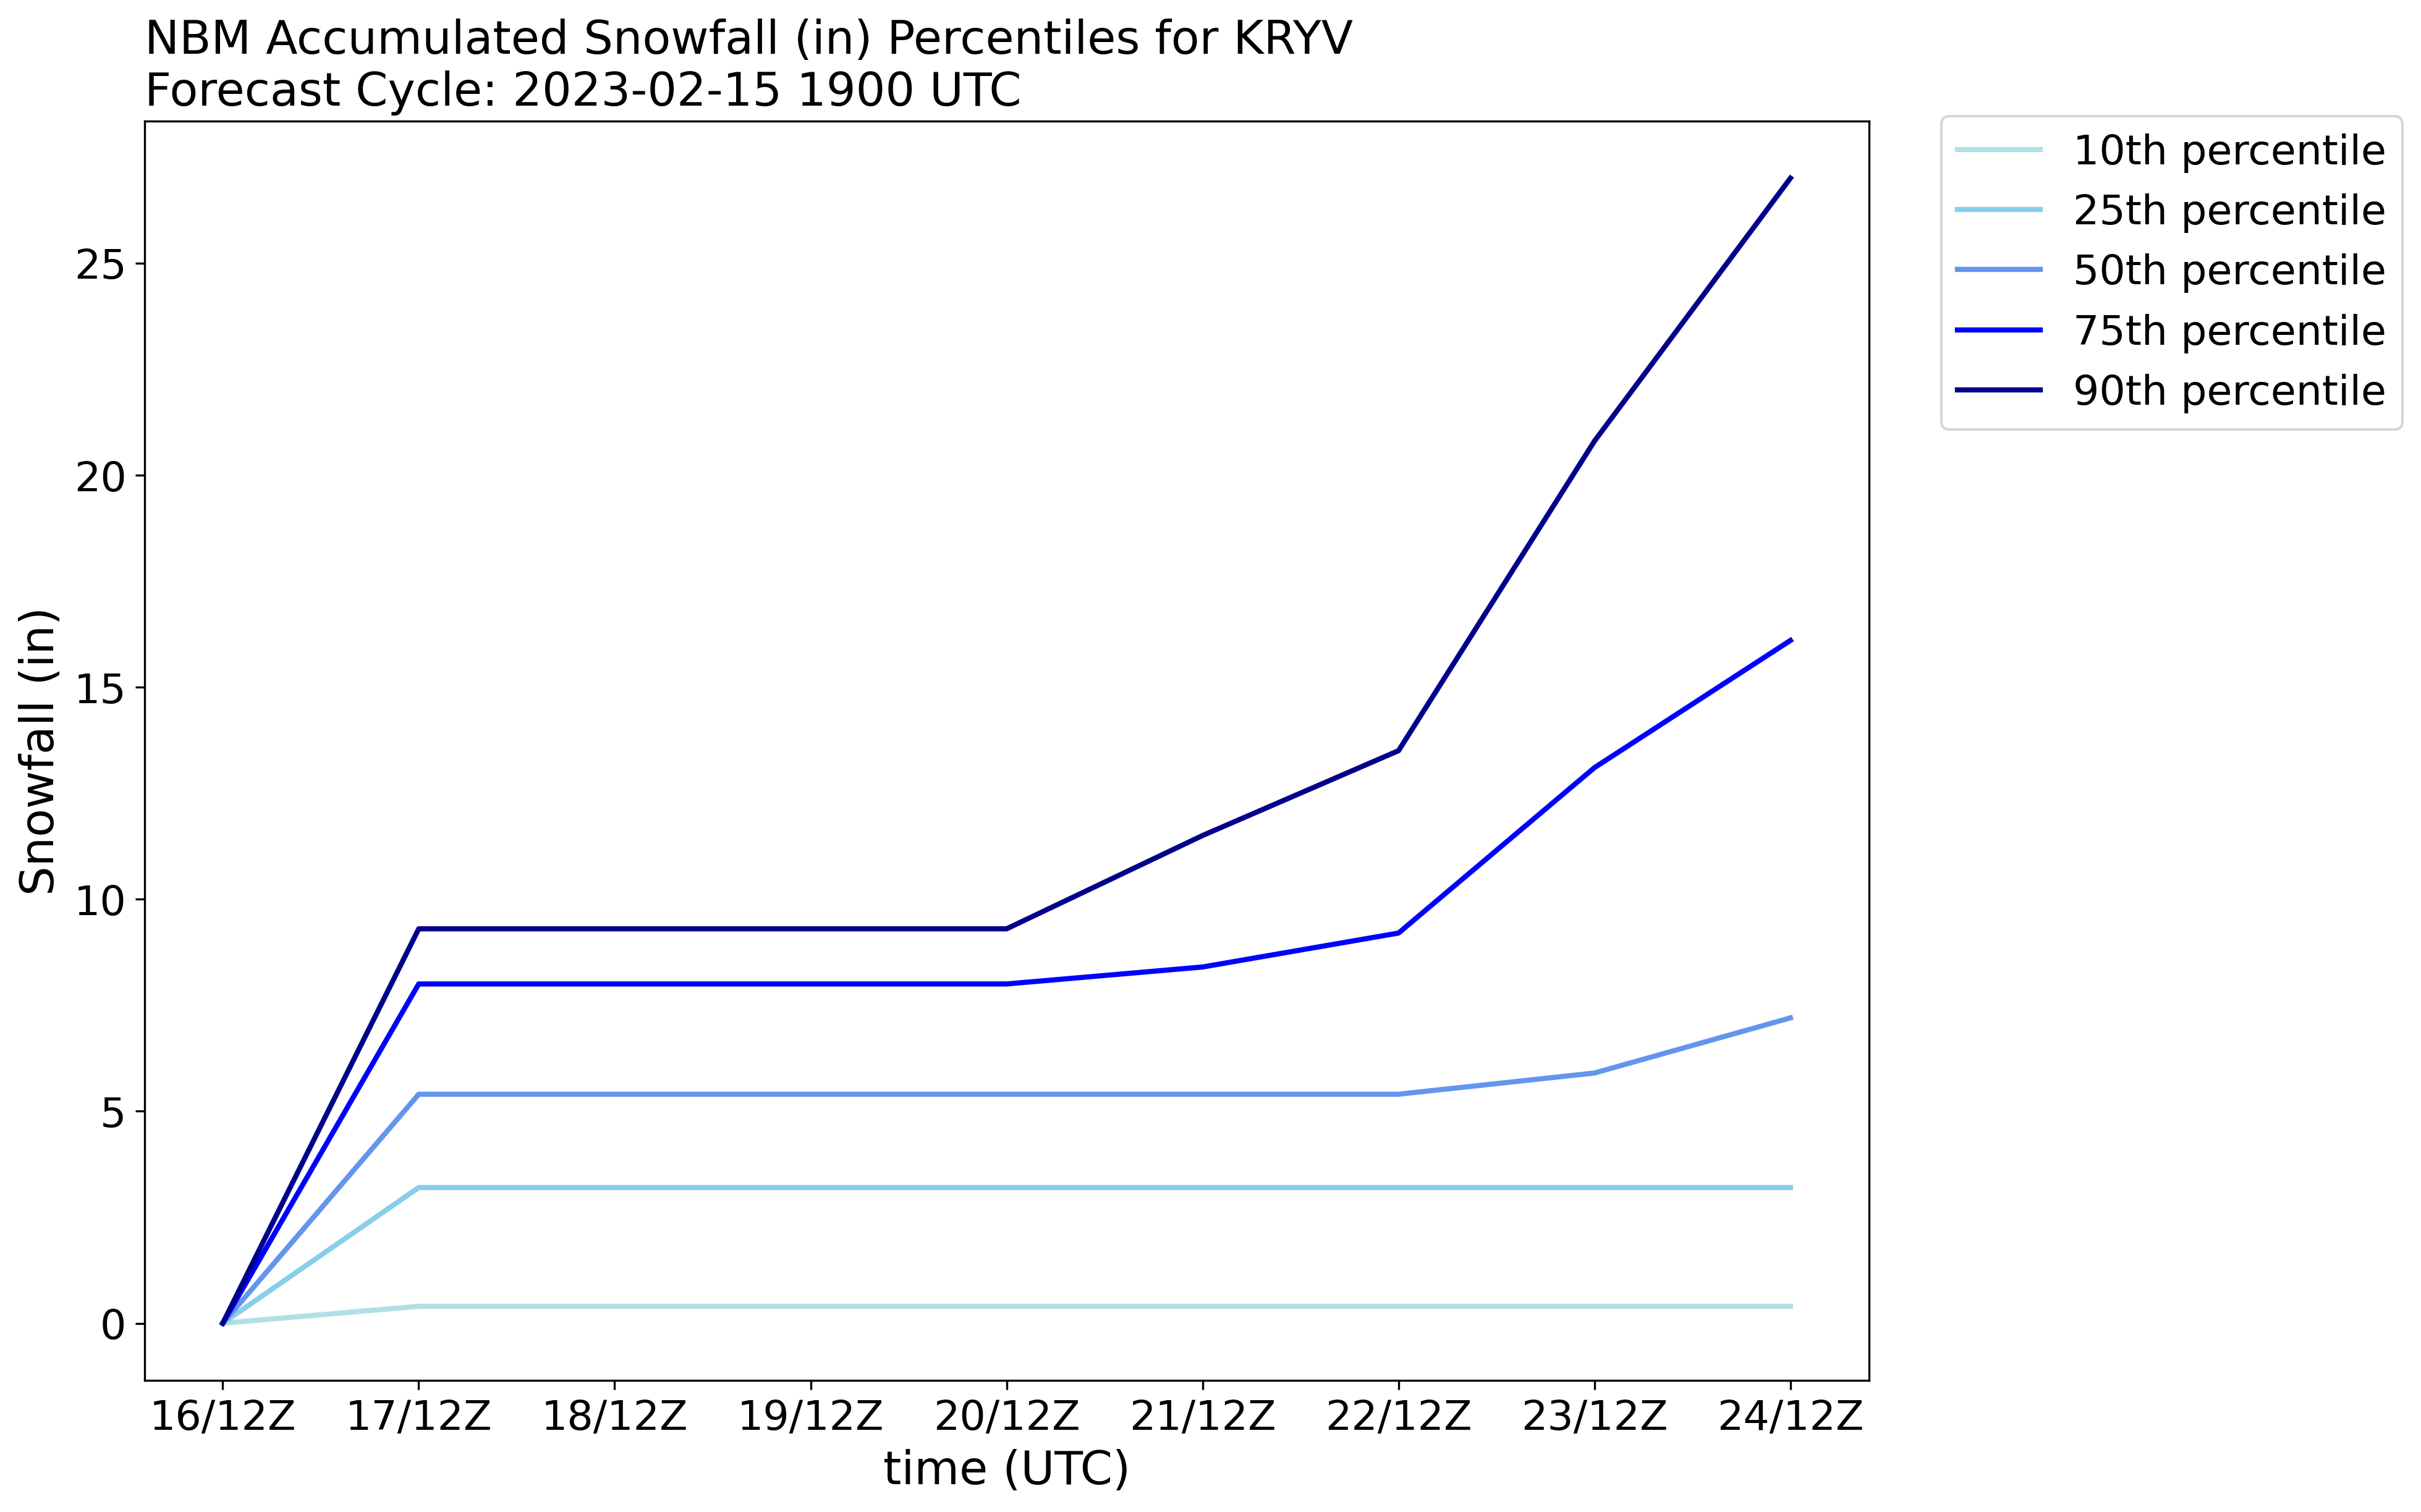

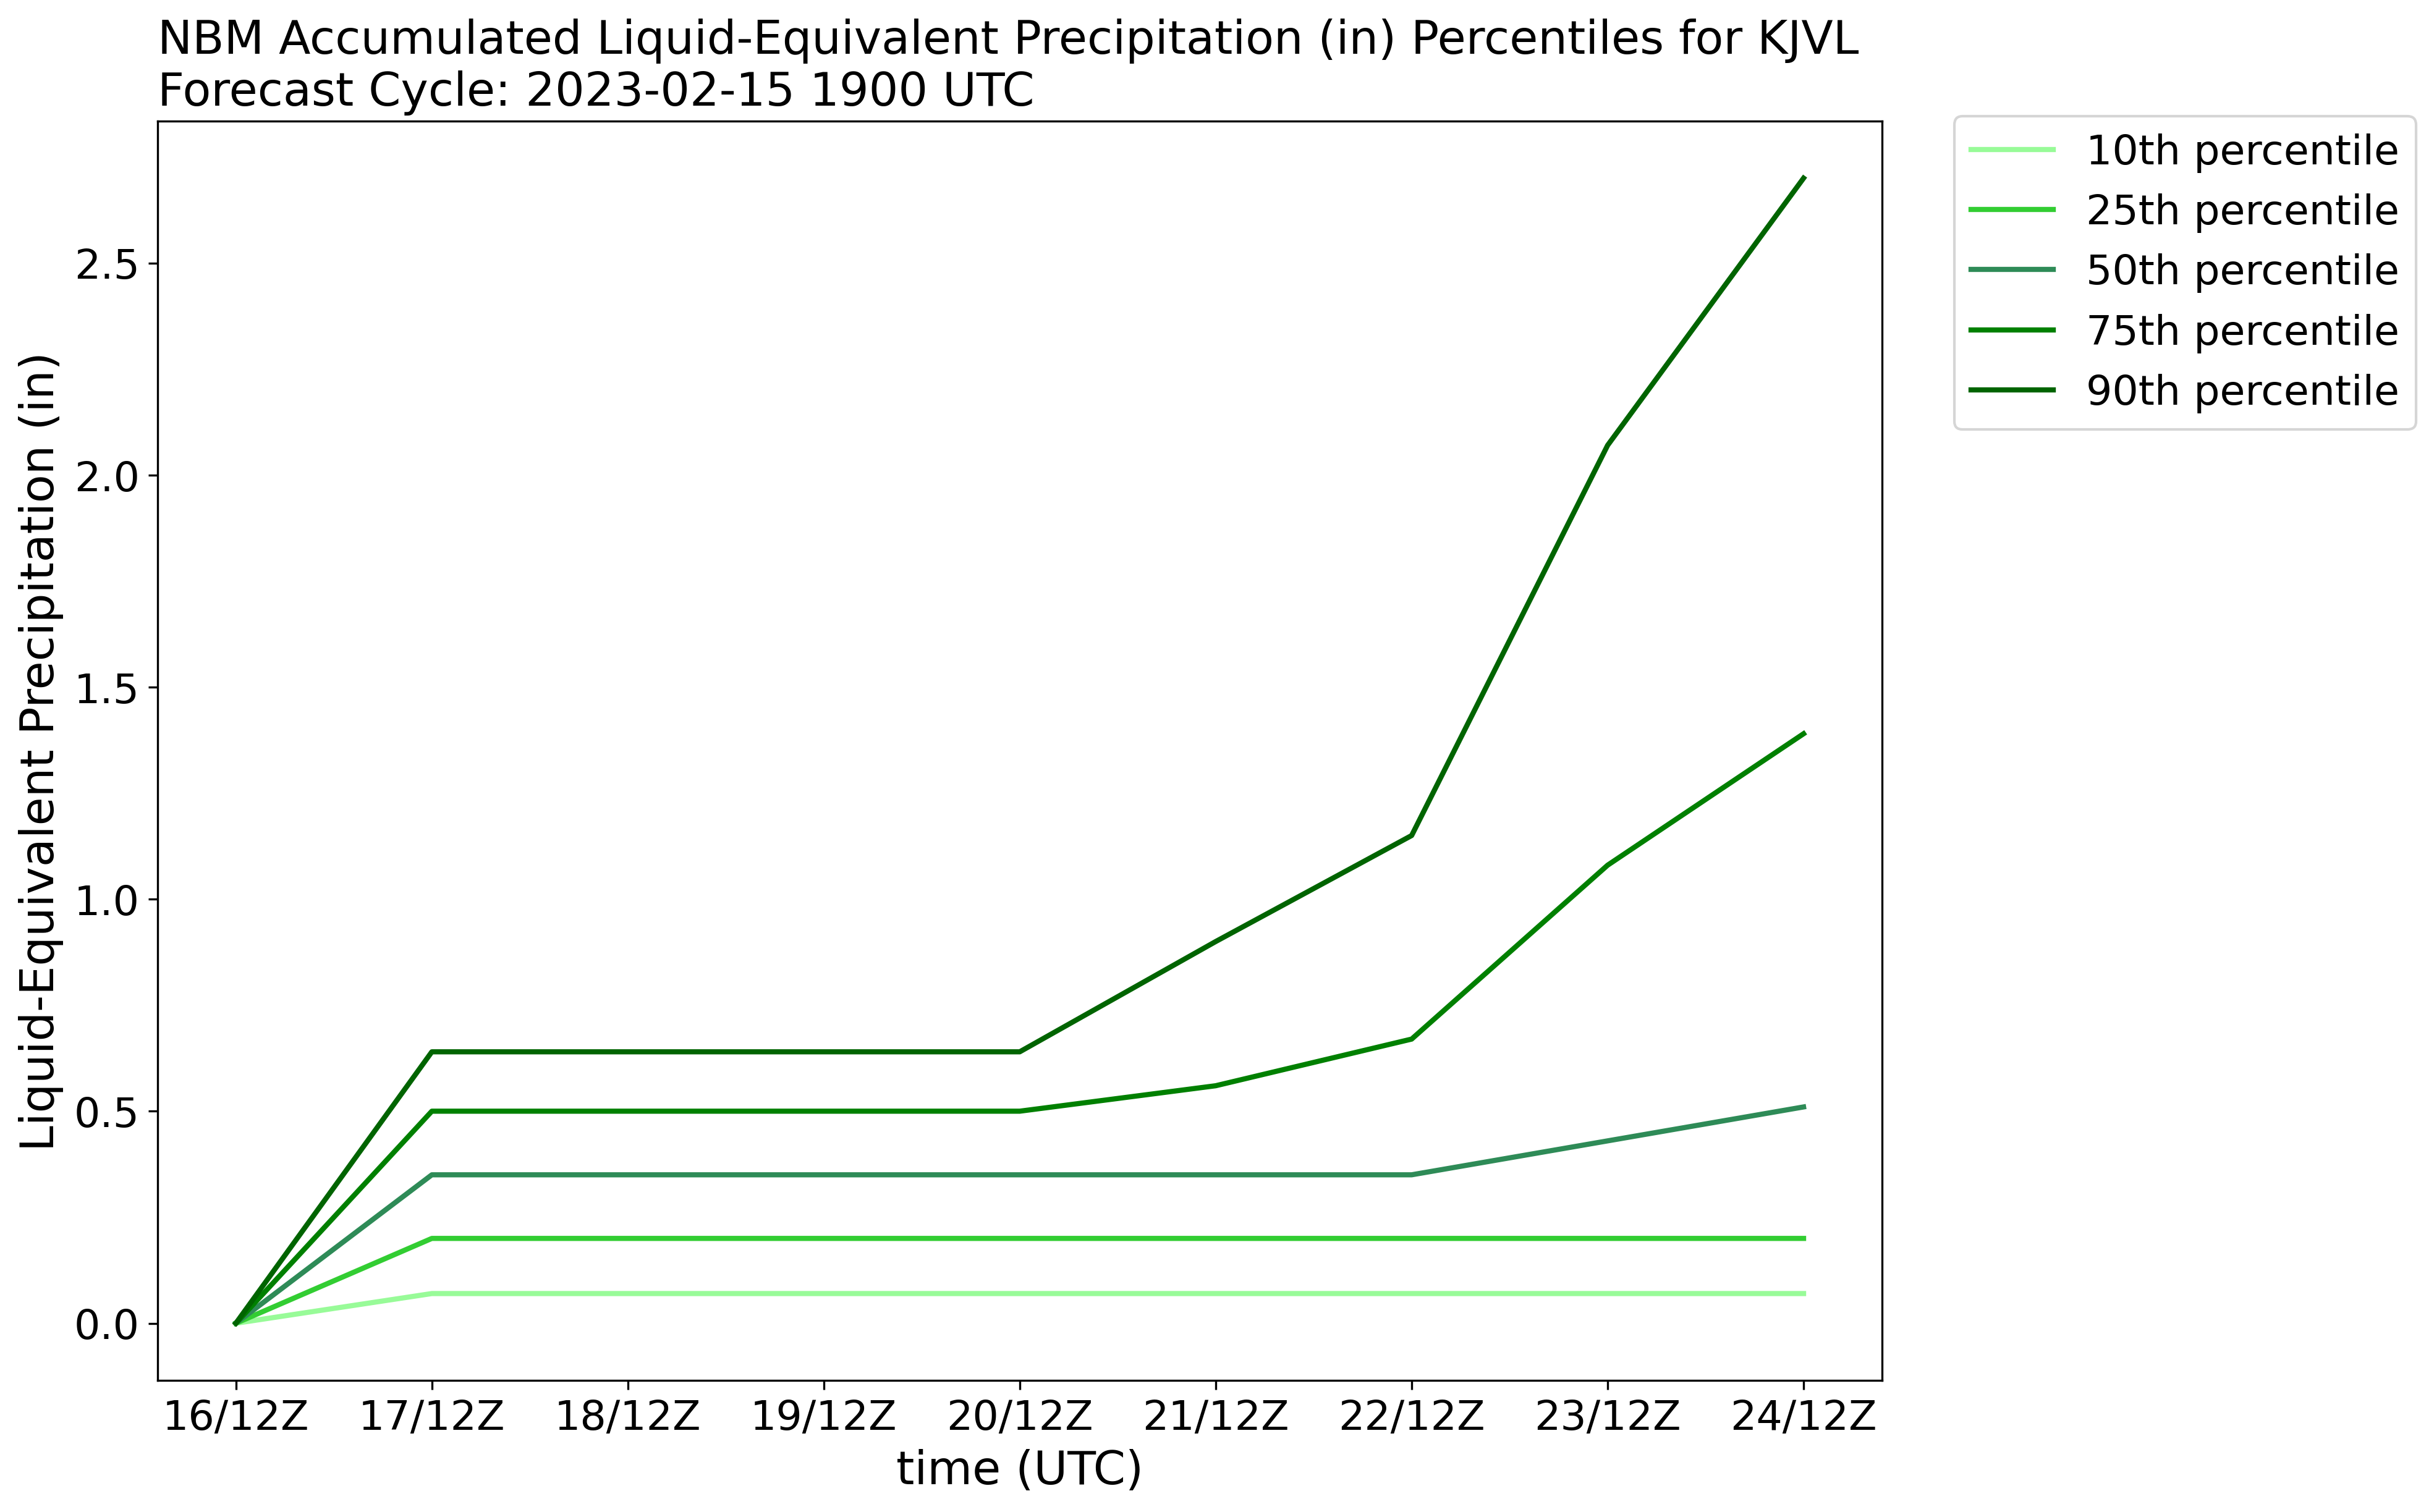

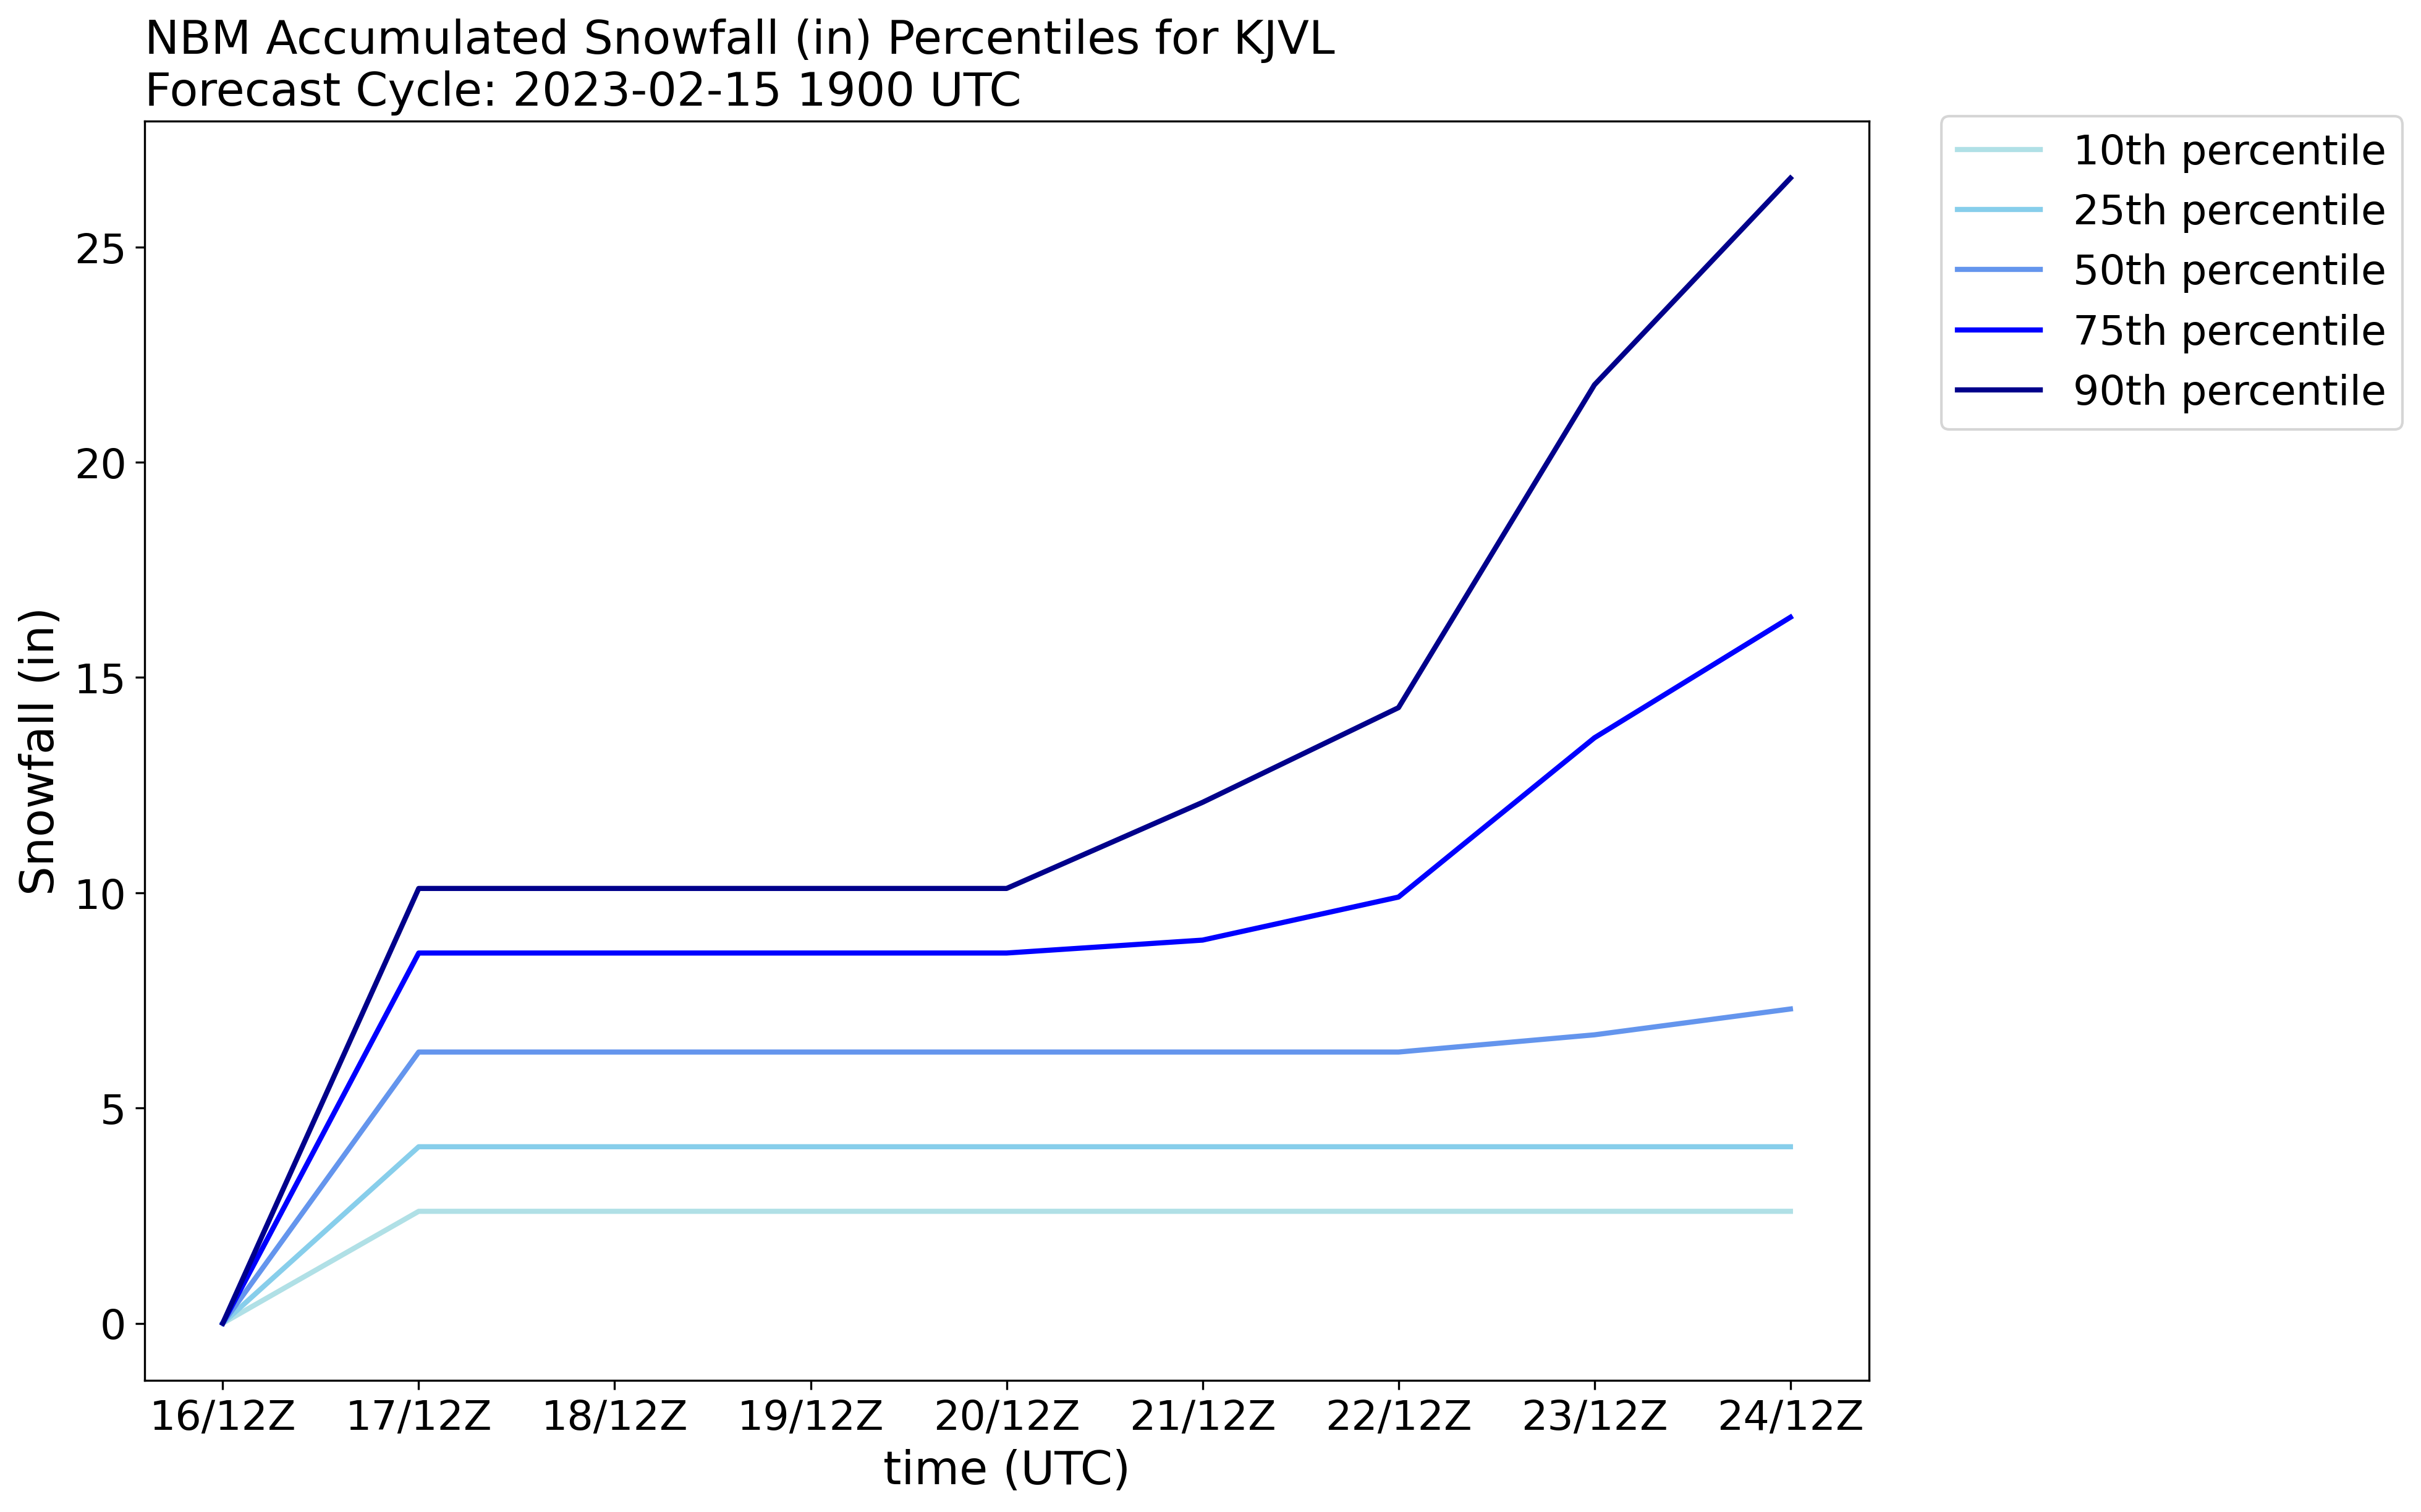

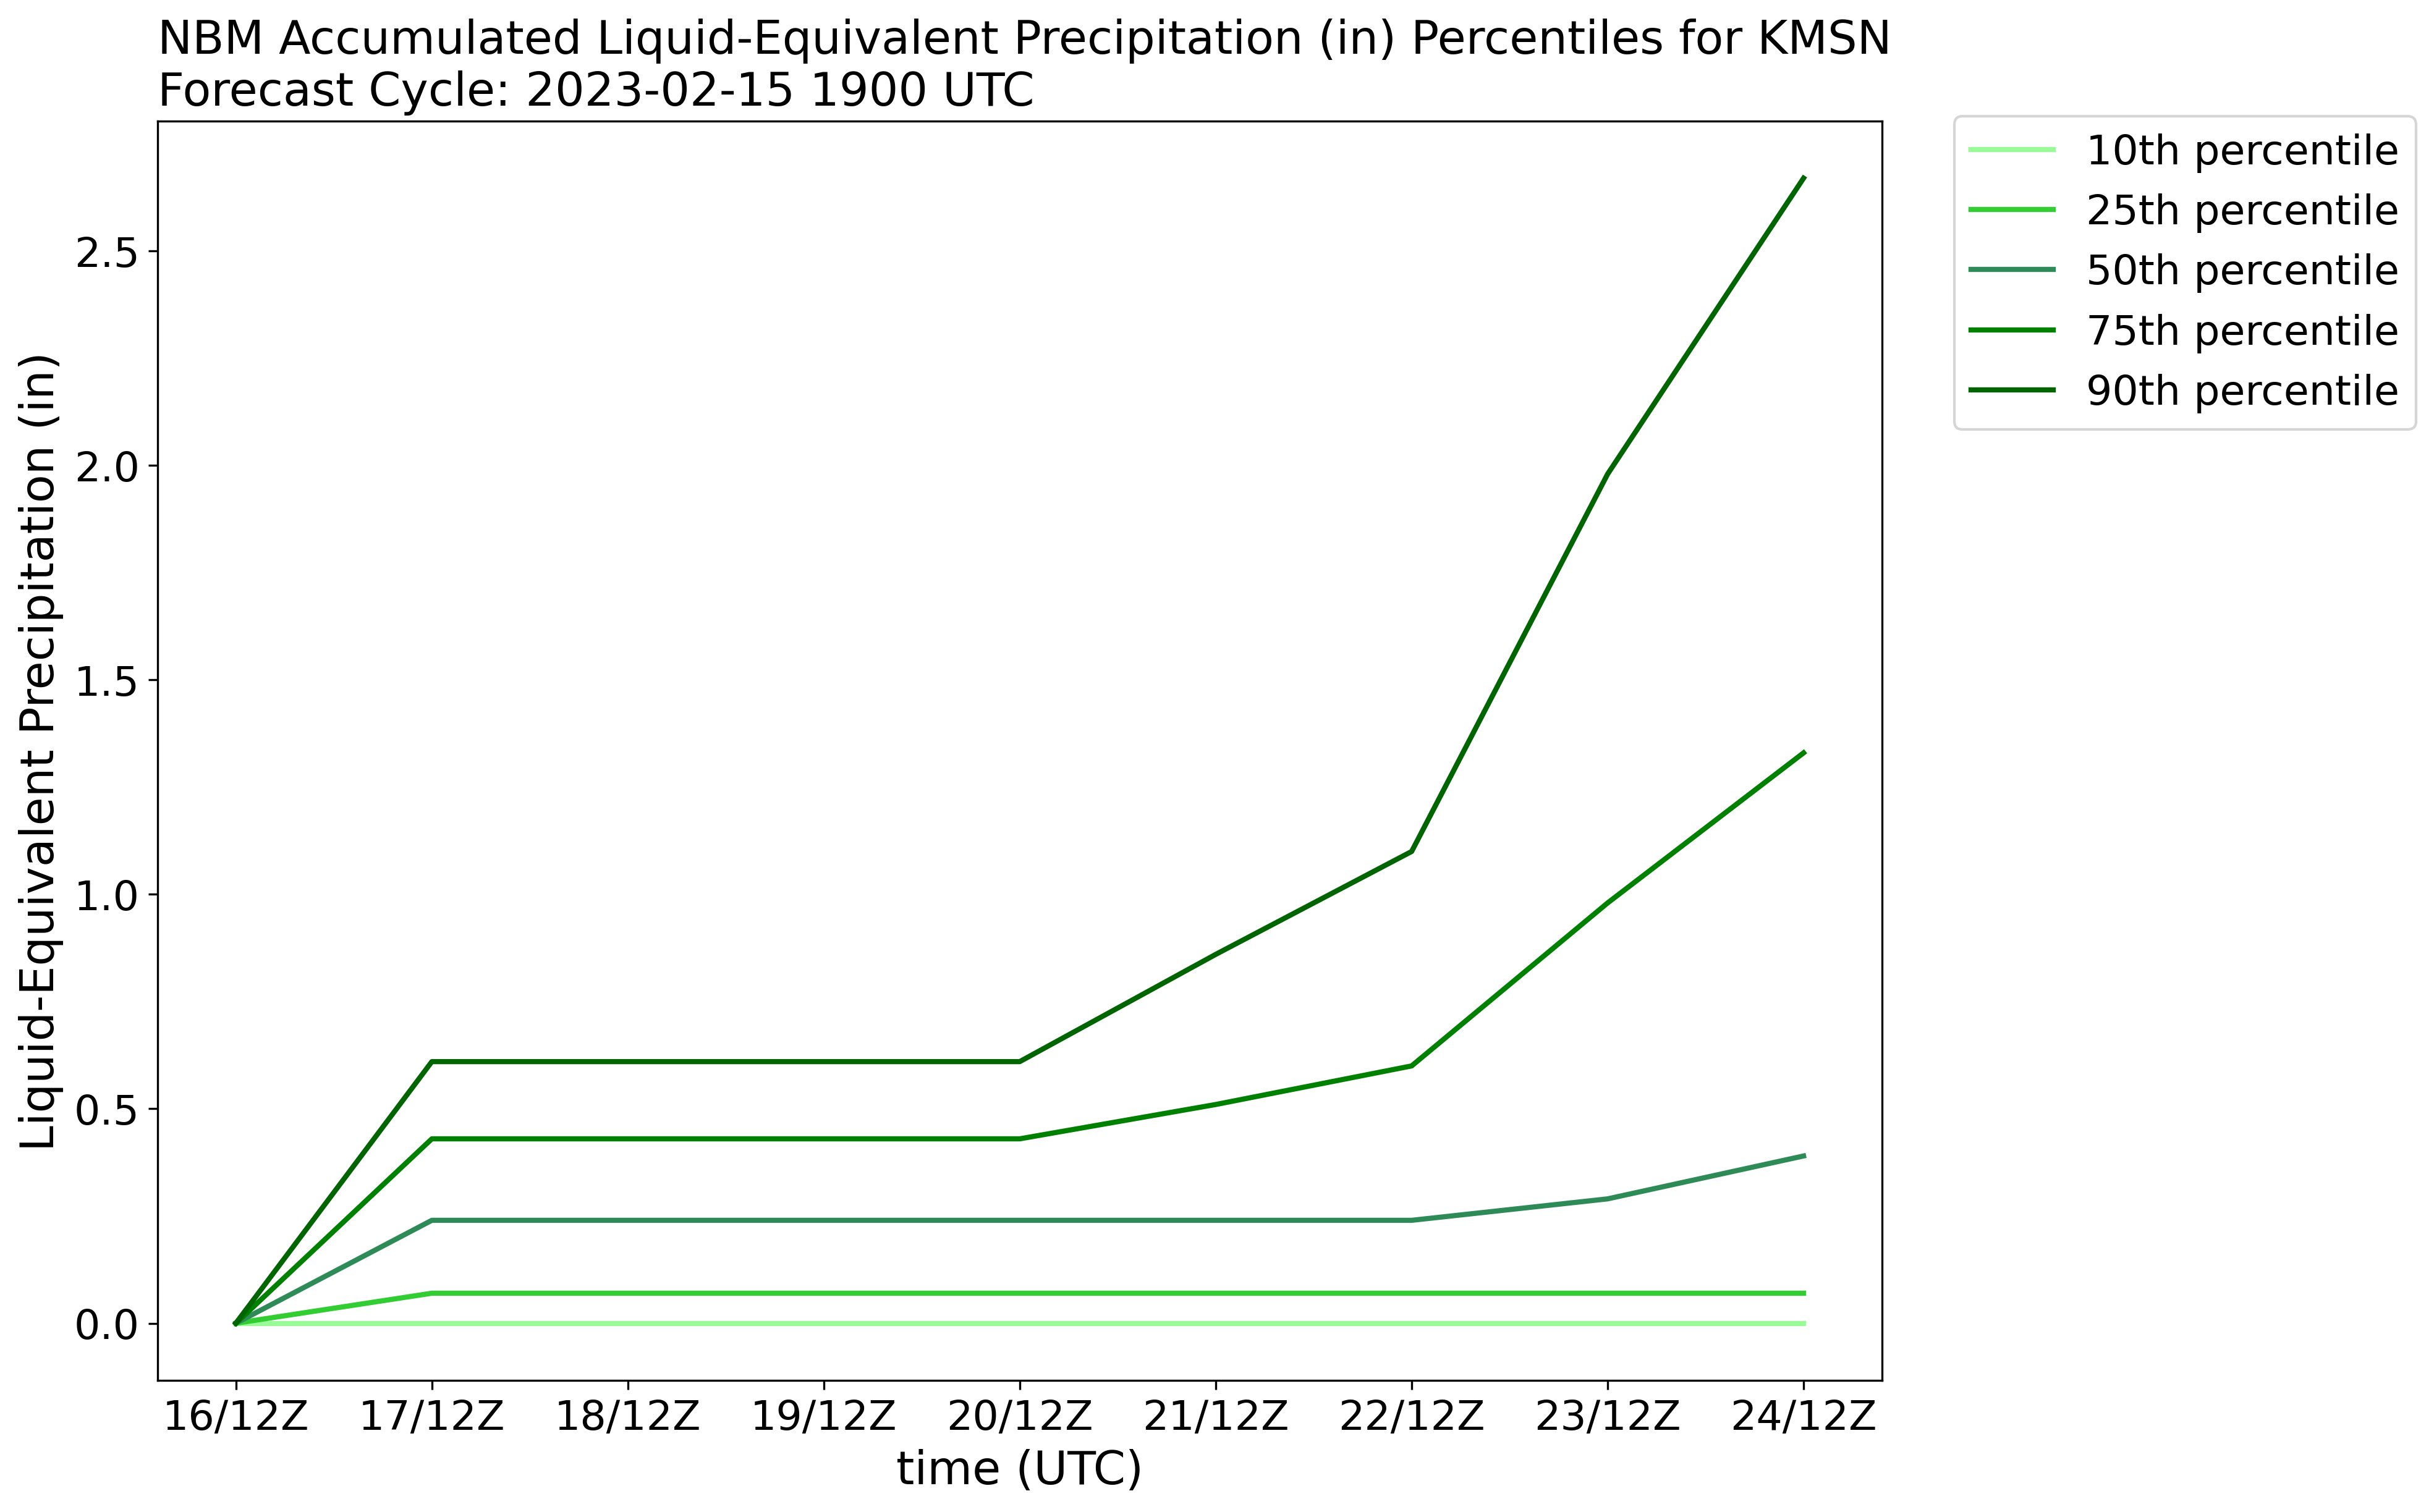

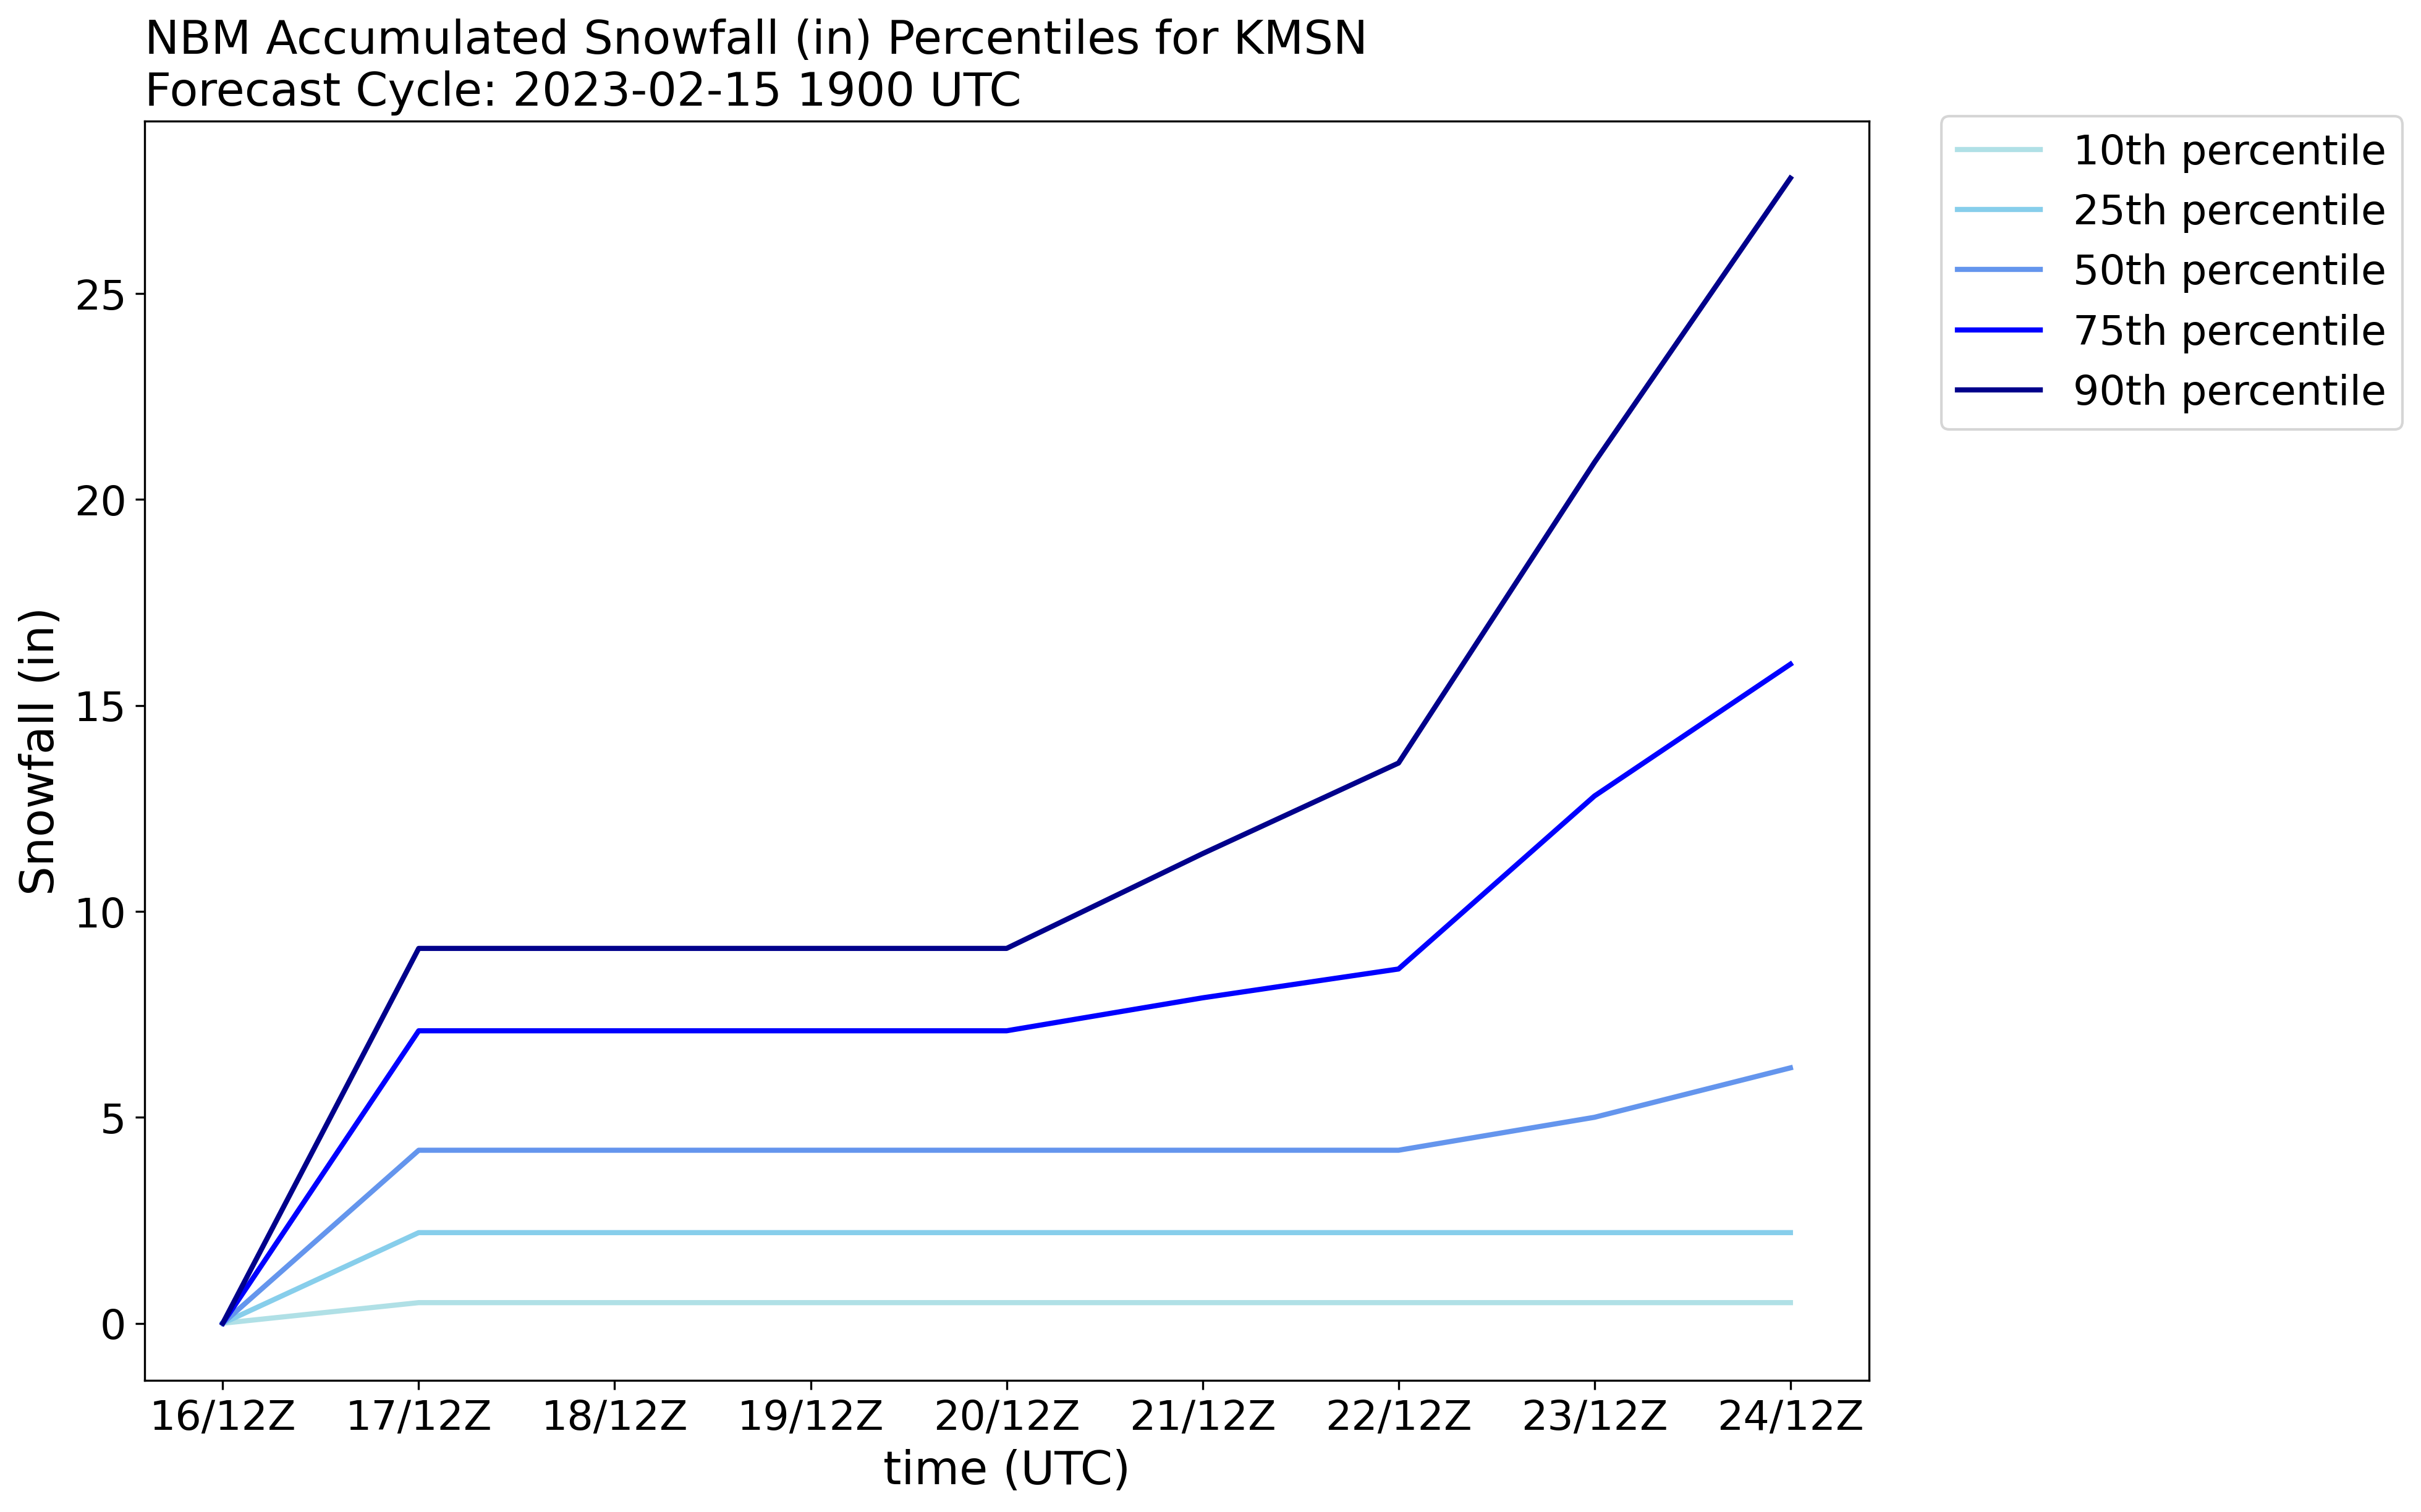

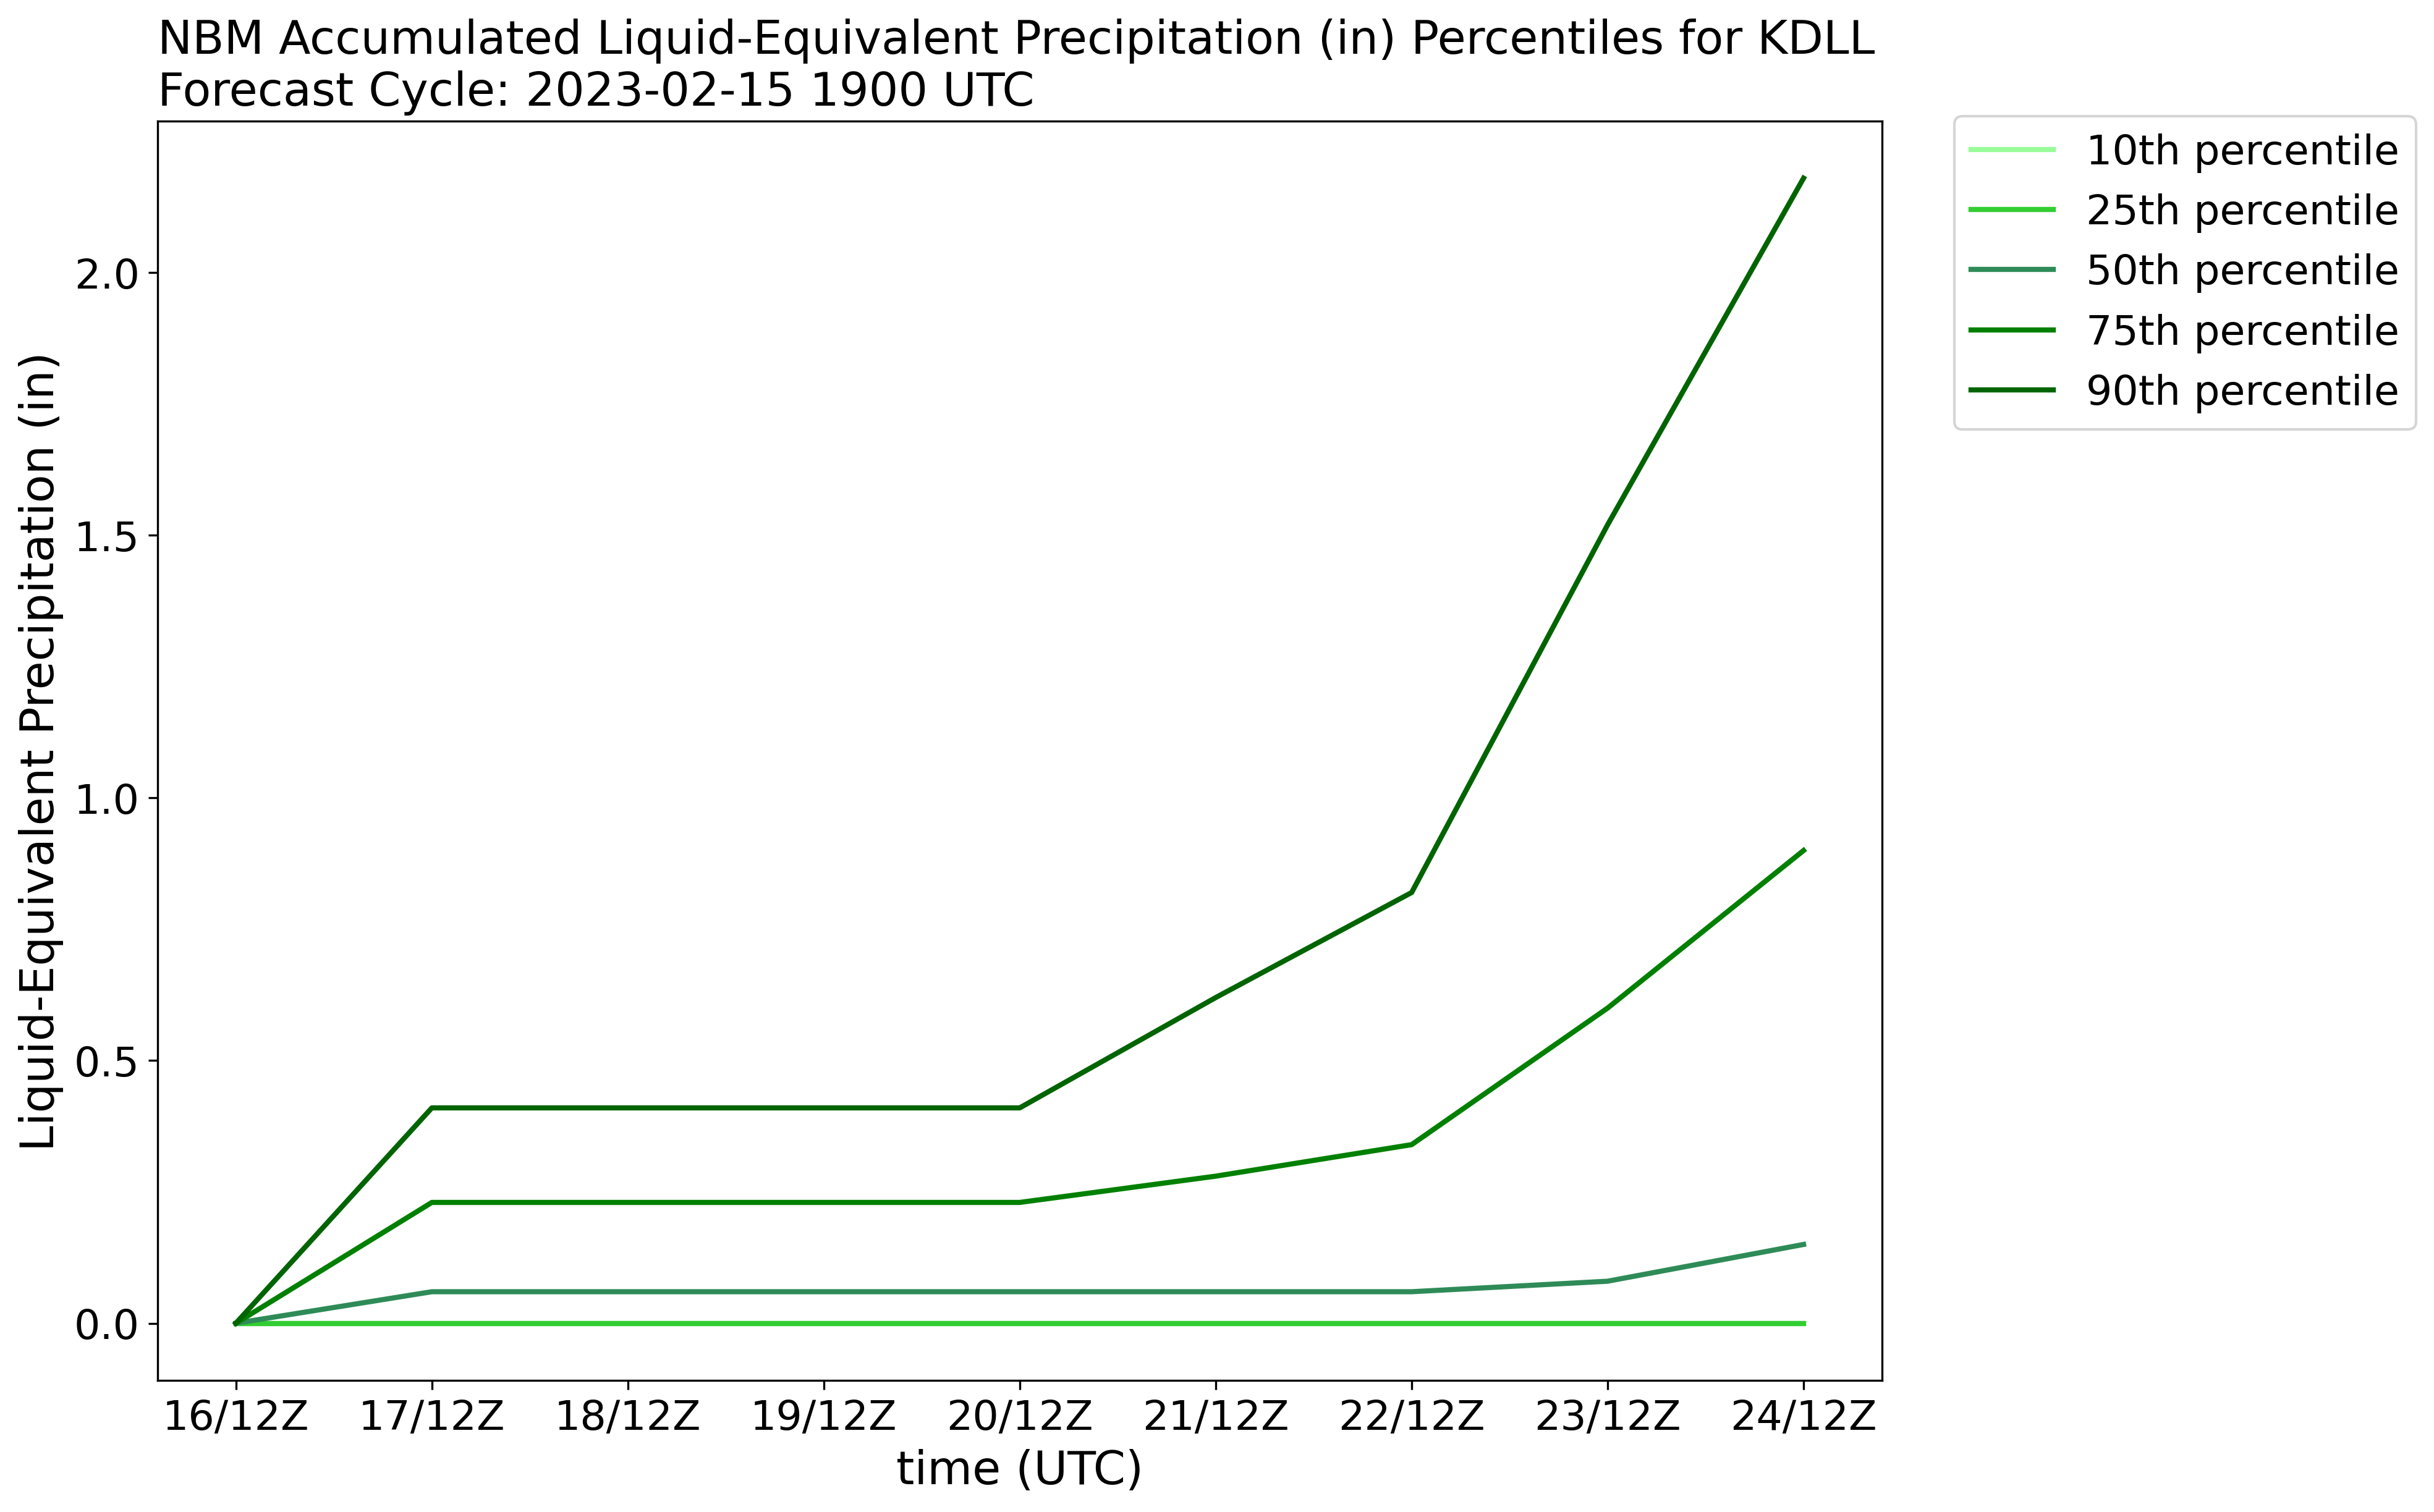

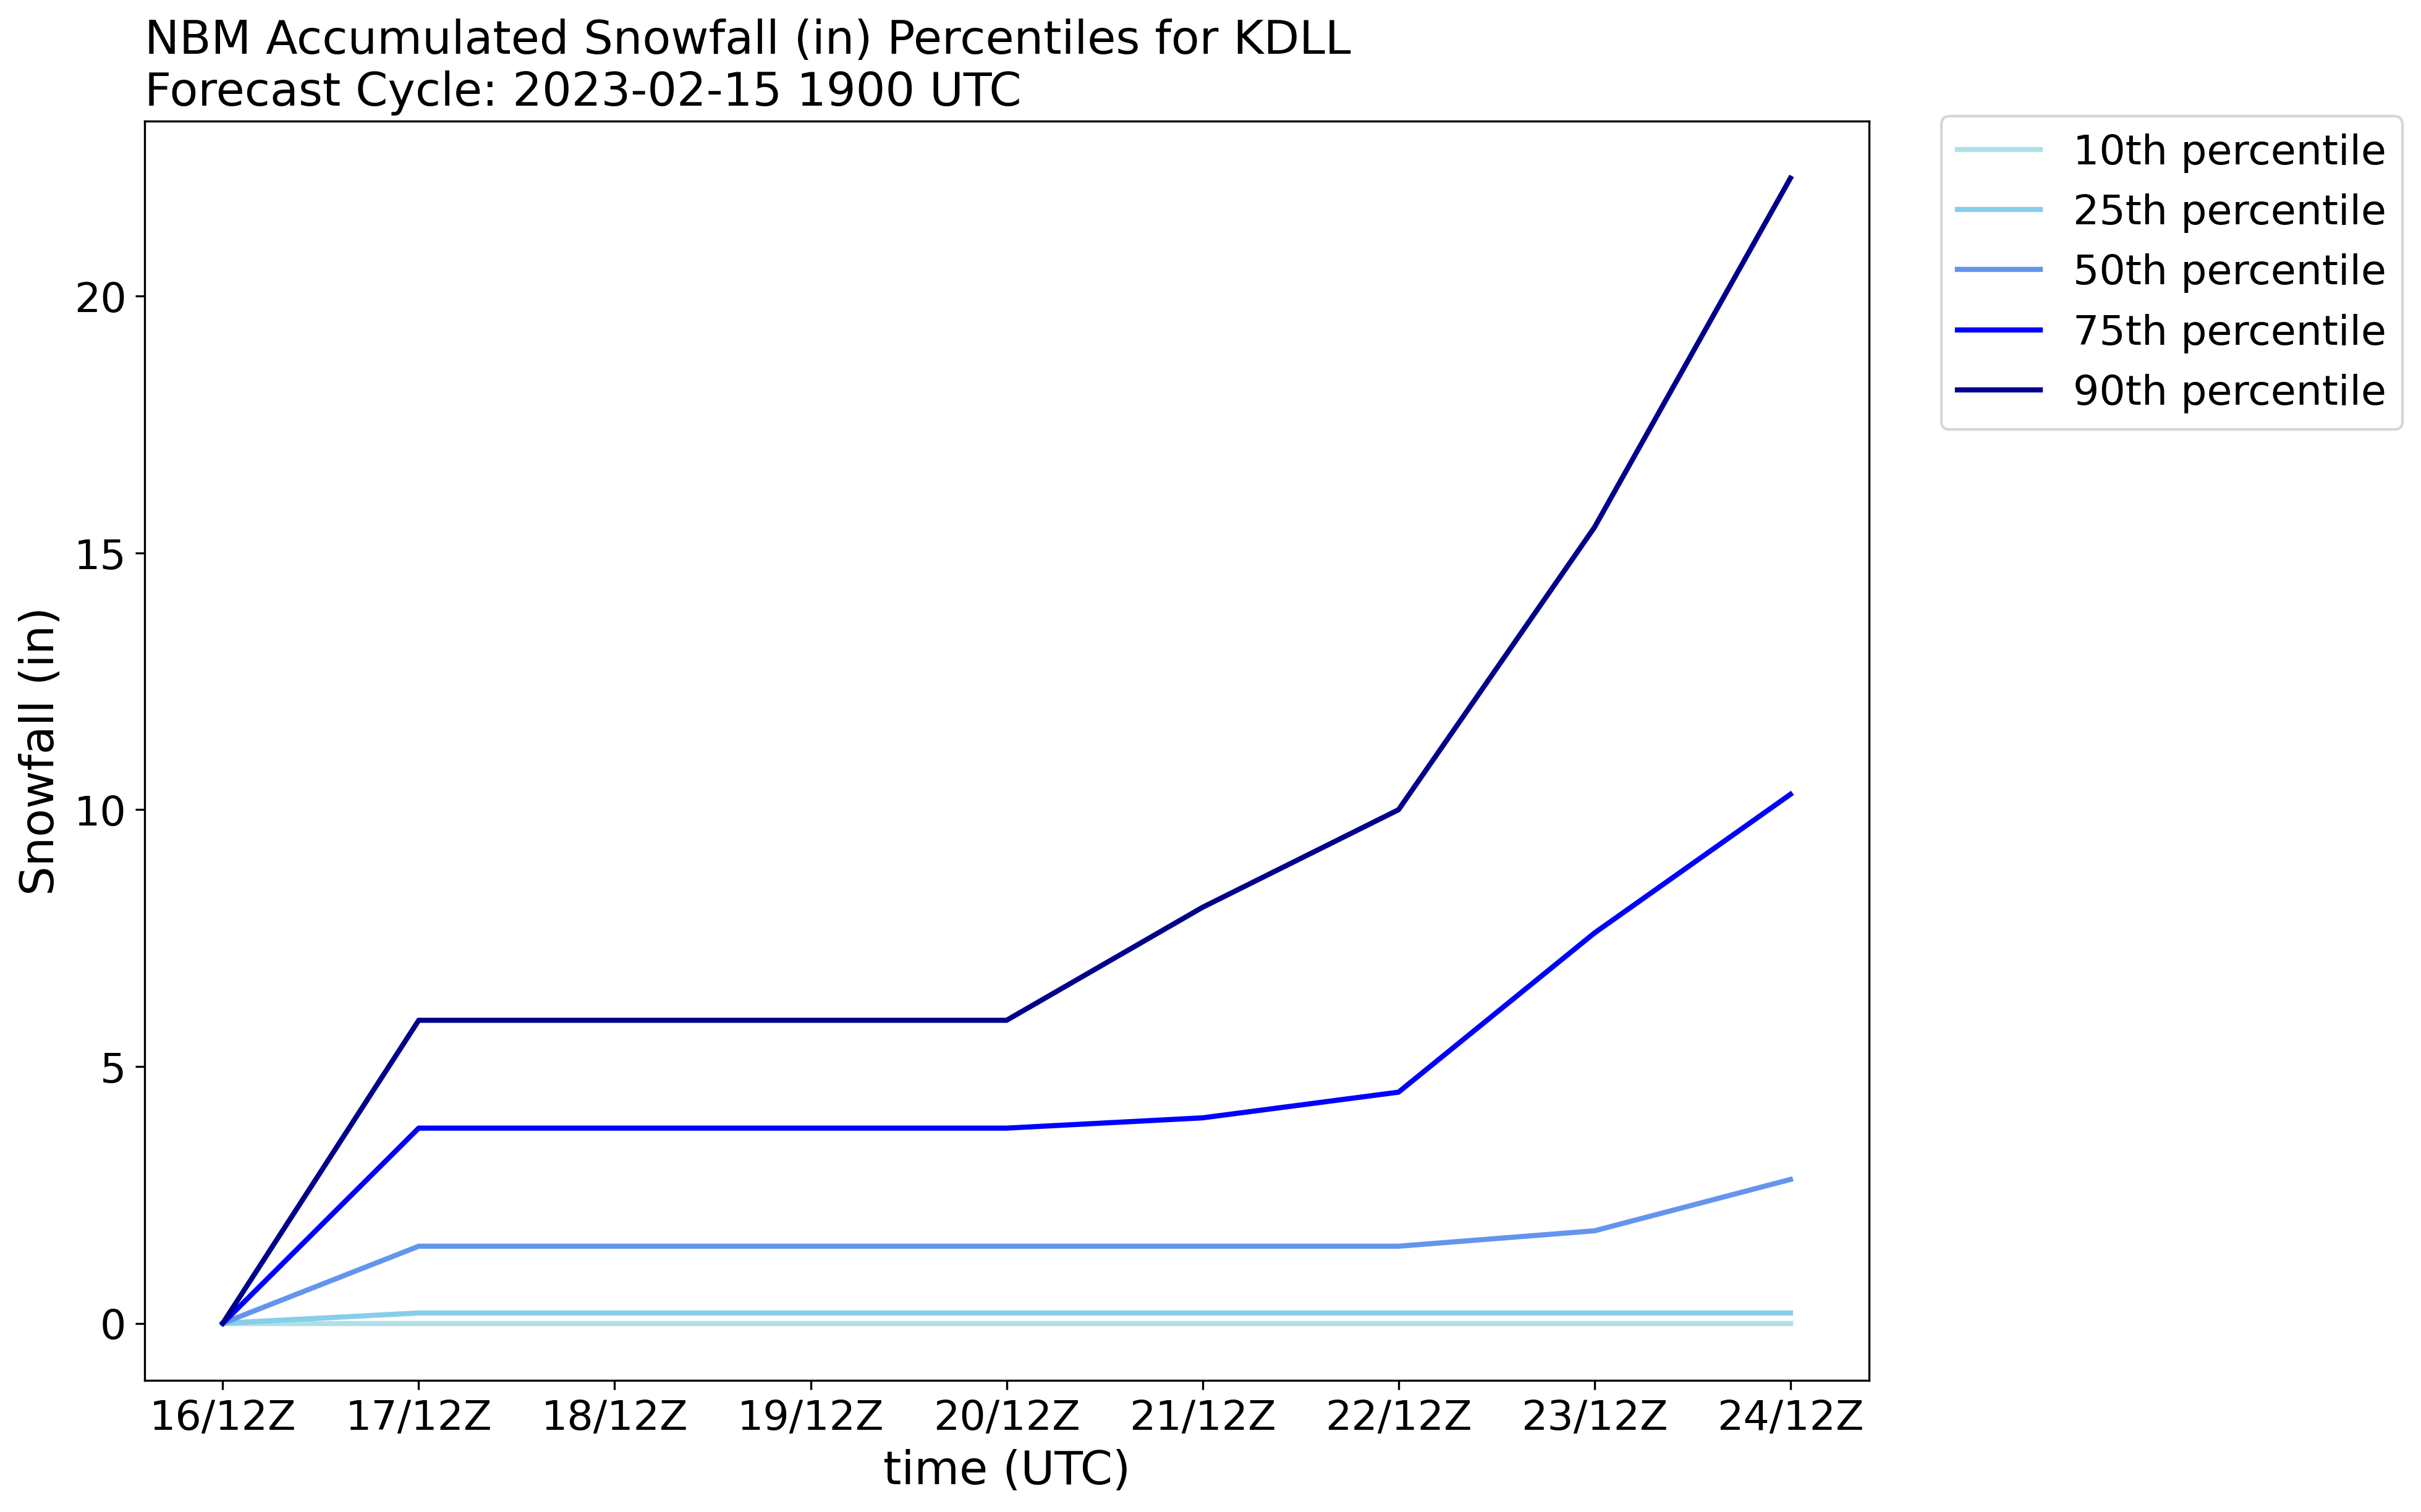

In [6]:
# Import necessary modules.
import pandas as pd
import numpy as np
from datetime import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt

# Get time information.
yr, mo, dd, hr, cols = parse_time()
dtgstr = str(yr)+'-'+str(mo)+'-'+str(dd)+' '+str(hr)+'00 UTC'

# Download file, using the column specifications above
# and passing in a list of names for the columns that
# corresponds to the forecast days.
df = pd.read_fwf('https://nomads.ncep.noaa.gov/pub/data/nccf/com/blend/prod/blend.'+str(yr)+str(mo)+str(dd)+'/'+str(hr)+'/text/blend_nbptx.t'+str(hr)+'z', colspecs=cols, 
                 header=None, names=['Field', 'Day 1', 'Day 2', 'Day 3', 'Day 4', 'Day 5', 'Day 6', 'Day 7', 'Day 8', 'Day 9'])

# Define list of stations, then iterate over them.
stations = ['KMKE', 'KENW', 'KUES', 'KETB', 'KSBM', 'KRYV', 'KJVL', 'KMSN', 'KDLL']
for station in stations:
    
# Reduce DataFrame to a single station's data.
    df_short = winnow_by_station(df, station)

# Define list of fields to plot, then iterate over them.
    fields_single = ['Q24', 'S24']
    for field_single in fields_single:
    
# Call plotting code for the desired field.
        plot_single(df_short, field_single, station, dtgstr)